# PostgreSQL. Основы языка SQL


> Примеры SQL-запросов из учебника переработаны с применением библиотеки `pandas`.

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
import warnings

warnings.simplefilter("ignore")

In [5]:
pd.__version__

'1.0.5'

## Развертывание базы данных

Hассмотрим как развернуть в вашем кластере PostgreSQL учебную базу данных «Авиаперевозки», подготовленную компанией Postgres Professional.

На сайте postgrespro.ru есть раздел, посвященный этой базе данных, найти его можно по ссылке https://postgrespro.ru/education/demodb. Она предоставляется в трех версиях, отличающихся только объемом данных: самая компактная версия содержит данные за один месяц, версия среднего размера охватывает временной период в три месяца, а самая полная версия включает данные за целый год. Все данные были сгенерированы с помощью специальных алгоритмов, обеспечивающих их «правдоподобность».

В качестве первого шага к развертыванию базы данных нужно скачать ее заархивированную резервную копию по ссылке https://edu.postgrespro.ru/demo_small.zip. Затем необходимо извлечь файл из архива: 

```bash
wget https://edu.postgrespro.ru/demo-small.zip

unzip demo_small.zip
```

Извлеченный файл называется demo_small.sql. Теперь создадим базу данных с име- нем demo в вашем кластере PostgreSQL. Самый краткий вариант команды будет таким: 

```bash
zcat demo-small.zip | psql
```
или

```bash
psql -f demo_small.sql -U postgres
```

Если вы хотите перенаправить вывод сообщений, которые генерирует СУБД в процессе работы, с экрана в файлы, то можно поступить так:

```bash
psql -f demo_small.sql -U postgres > demo.log 2>demo.err
```

Можно разделить стандартное устройство вывода и стандартное устройство вывода ошибок. Обычные сообщения будут перенаправлены в файл demo.log, а сообщения об ошибках — в файл demo.err. Обратите внимание, что между цифрой 2, обозначающей дескриптор стандартного устройства вывода сообщений об ошибках, и знаком «>», обозначающим переадресацию вывода, не должно быть пробела.

Если вам удобнее собрать все сообщения в один общий файл, тогда нужно сделать так:

```bash
psql -f demo_small.sql -U postgres > demo.log 2>&1
```

Обратите внимание, что все выражение 2>&1 в конце команды пишется без пробелов. Оно указывает операционной системе, что сообщения об ошибках нужно направить туда же, куда выводятся и обычные сообщения.

Если бы наш SQL-файл был очень большим, тогда можно было бы выполнить команду в фоновом режиме, поставив в конце командной строки символ «&», а за ходом процесса в реальном времени наблюдать с помощью команды tail.

```bash
psql -f demo_small.sql -U postgres > demo.log 2>&1 & tail -f demo.log
```

Выберите один из предложенных вариантов команды для развертывания базы данных и выполните эту команду.
Все готово! Можно подключаться к новой базе данных:

```bash
psql -d demo -U postgres
```

## Схема базы данных
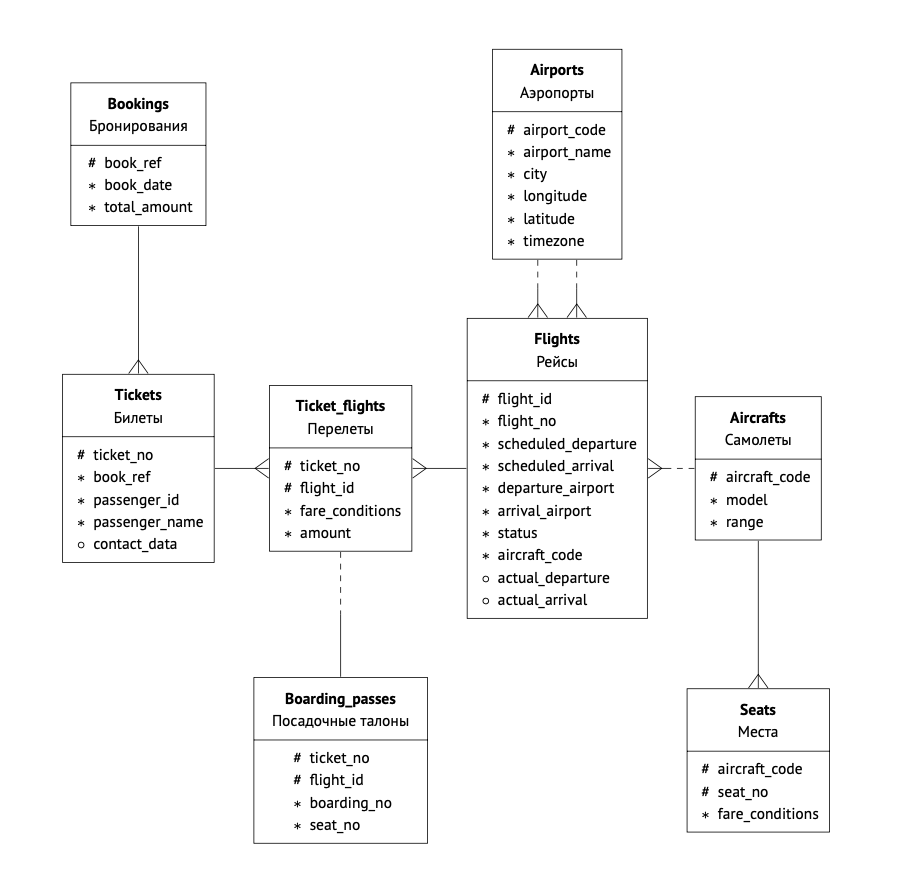

## Загрузка данных в датафреймы

Для связи Python с СУБД PostgreSQL будем использовать библиотеку `psycopg2`

In [6]:
psycopg2.__version__

'2.8.6 (dt dec pq3 ext lo64)'

In [2]:
conn = psycopg2.connect(**json.load(open('pgconfig.json')))

### `aircrafts`

In [3]:
query = """SELECT * FROM bookings.aircrafts;"""

aircrafts = pd.read_sql(query, conn)
aircrafts.head()

,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
2,SU9,Sukhoi SuperJet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600


### `bookings`

In [4]:
query = """SELECT * FROM bookings.bookings;"""

bookings = pd.read_sql(query, conn)
bookings.head()

,book_ref,book_date,total_amount
0,00000F,2016-09-01 23:12:00+00:00,265700.0
1,000012,2016-09-11 05:02:00+00:00,37900.0
2,000068,2016-10-13 10:27:00+00:00,18100.0
3,000181,2016-10-08 09:28:00+00:00,131800.0
4,0002D8,2016-10-05 17:40:00+00:00,23600.0


### `airports`

In [5]:
query = """SELECT * FROM bookings.airports;"""

airports = pd.read_sql(query, conn)
airports.head()

,airport_code,airport_name,city,longitude,latitude,timezone
0,MJZ,Мирный,Мирный,114.038928,62.534689,Asia/Yakutsk
1,NBC,Бегишево,Нижнекамск,52.060000,55.340000,Europe/Moscow
2,NOZ,Спиченково,Новокузнецк,86.877200,53.811400,Asia/Novokuznetsk
3,NAL,Нальчик,Нальчик,43.636600,43.512900,Europe/Moscow
4,OGZ,Беслан,Владикавказ,44.606600,43.205100,Europe/Moscow


### `routes`

In [6]:
query = """SELECT * FROM bookings.routes;"""

routes = pd.read_sql(query, conn)
routes.head()

,flight_no,departure_airport,departure_airport_name,departure_city,arrival_airport,arrival_airport_name,arrival_city,aircraft_code,duration,days_of_week
0,PG0001,UIK,Усть-Илимск,Усть-Илимск,SGC,Сургут,Сургут,CR2,02:20:00,[1]
1,PG0002,SGC,Сургут,Сургут,UIK,Усть-Илимск,Усть-Илимск,CR2,02:20:00,[2]
2,PG0003,IWA,Иваново-Южный,Иваново,AER,Сочи,Сочи,CR2,02:10:00,"[1, 4]"
3,PG0004,AER,Сочи,Сочи,IWA,Иваново-Южный,Иваново,CR2,02:10:00,"[2, 5]"
4,PG0005,DME,Домодедово,Москва,PKV,Псков,Псков,CN1,02:05:00,"[2, 4, 7]"


### `tickets`

In [7]:
query = """SELECT * FROM bookings.tickets;"""

tickets = pd.read_sql(query, conn)
tickets.head()

,ticket_no,book_ref,passenger_id,passenger_name,contact_data
0,0005432000987,06B046,8149 604011,VALERIY TIKHONOV,{'phone': '+70127117011'}
1,0005432000988,06B046,8499 420203,EVGENIYA ALEKSEEVA,{'phone': '+70378089255'}
2,0005432000989,E170C3,1011 752484,ARTUR GERASIMOV,{'phone': '+70760429203'}
3,0005432000990,E170C3,4849 400049,ALINA VOLKOVA,{'email': 'volkova.alina_03101973@postgrespro....
4,0005432000991,F313DD,6615 976589,MAKSIM ZHUKOV,"{'email': 'm-zhukov061972@postgrespro.ru', 'ph..."


### `seats`

In [8]:
query = """SELECT * FROM bookings.seats;"""

seats = pd.read_sql(query, conn)
seats.head()

,aircraft_code,seat_no,fare_conditions
0,319,2A,Business
1,319,2C,Business
2,319,2D,Business
3,319,2F,Business
4,319,3A,Business


### `ticket_flights`

In [9]:
query = """SELECT * FROM bookings.ticket_flights;"""

ticket_flights = pd.read_sql(query, conn)
ticket_flights.head()

,ticket_no,flight_id,fare_conditions,amount
0,0005432159776,30625,Business,42100.0
1,0005435212351,30625,Business,42100.0
2,0005435212386,30625,Business,42100.0
3,0005435212381,30625,Business,42100.0
4,0005432211370,30625,Business,42100.0


### `flights_v`

In [10]:
query = """SELECT * FROM bookings.flights_v;"""

flights_v = pd.read_sql(query, conn)
flights_v.head()

,flight_id,flight_no,scheduled_departure,scheduled_departure_local,scheduled_arrival,scheduled_arrival_local,scheduled_duration,departure_airport,departure_airport_name,departure_city,arrival_airport,arrival_airport_name,arrival_city,status,aircraft_code,actual_departure,actual_departure_local,actual_arrival,actual_arrival_local,actual_duration
0,1,PG0405,2016-09-13 05:35:00+00:00,2016-09-13 08:35:00,2016-09-13 06:30:00+00:00,2016-09-13 09:30:00,00:55:00,DME,Домодедово,Москва,LED,Пулково,Санкт-Петербург,Arrived,321,2016-09-13 05:44:00+00:00,2016-09-13 08:44:00,2016-09-13 06:39:00+00:00,2016-09-13 09:39:00,00:55:00
1,2,PG0404,2016-10-03 15:05:00+00:00,2016-10-03 18:05:00,2016-10-03 16:00:00+00:00,2016-10-03 19:00:00,00:55:00,DME,Домодедово,Москва,LED,Пулково,Санкт-Петербург,Arrived,321,2016-10-03 15:06:00+00:00,2016-10-03 18:06:00,2016-10-03 16:01:00+00:00,2016-10-03 19:01:00,00:55:00
2,3,PG0405,2016-10-03 05:35:00+00:00,2016-10-03 08:35:00,2016-10-03 06:30:00+00:00,2016-10-03 09:30:00,00:55:00,DME,Домодедово,Москва,LED,Пулково,Санкт-Петербург,Arrived,321,2016-10-03 05:39:00+00:00,2016-10-03 08:39:00,2016-10-03 06:34:00+00:00,2016-10-03 09:34:00,00:55:00
3,4,PG0402,2016-11-07 08:25:00+00:00,2016-11-07 11:25:00,2016-11-07 09:20:00+00:00,2016-11-07 12:20:00,00:55:00,DME,Домодедово,Москва,LED,Пулково,Санкт-Петербург,Scheduled,321,NaT,NaT,NaT,NaT,NaT
4,5,PG0405,2016-10-14 05:35:00+00:00,2016-10-14 08:35:00,2016-10-14 06:30:00+00:00,2016-10-14 09:30:00,00:55:00,DME,Домодедово,Москва,LED,Пулково,Санкт-Петербург,On Time,321,NaT,NaT,NaT,NaT,NaT


### `flights`

In [11]:
query = """SELECT * FROM bookings.flights;"""

flights = pd.read_sql(query, conn)
flights.head()

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1,PG0405,2016-09-13 05:35:00+00:00,2016-09-13 06:30:00+00:00,DME,LED,Arrived,321,2016-09-13 05:44:00+00:00,2016-09-13 06:39:00+00:00
1,2,PG0404,2016-10-03 15:05:00+00:00,2016-10-03 16:00:00+00:00,DME,LED,Arrived,321,2016-10-03 15:06:00+00:00,2016-10-03 16:01:00+00:00
2,3,PG0405,2016-10-03 05:35:00+00:00,2016-10-03 06:30:00+00:00,DME,LED,Arrived,321,2016-10-03 05:39:00+00:00,2016-10-03 06:34:00+00:00
3,4,PG0402,2016-11-07 08:25:00+00:00,2016-11-07 09:20:00+00:00,DME,LED,Scheduled,321,NaT,NaT
4,5,PG0405,2016-10-14 05:35:00+00:00,2016-10-14 06:30:00+00:00,DME,LED,On Time,321,NaT,NaT


### `boarding_passes`

In [12]:
query = """SELECT * FROM bookings.boarding_passes;"""

boarding_passes = pd.read_sql(query, conn)
boarding_passes.head()

,ticket_no,flight_id,boarding_no,seat_no
0,0005435212351,30625,1,2D
1,0005435212386,30625,2,3G
2,0005435212381,30625,3,4H
3,0005432211370,30625,4,5D
4,0005435212357,30625,5,11A


Попытаемся с помощью Python и библиотеки pandas реализовать все учебные примеры, представленные на чистом SQL (диалекте PostgreSQL).

##  Выборки

Для начала поставим перед собой такую задачу: выбрать все самолеты компании Airbus. В этом нам поможет оператор поиска шаблонов `LIKE`:

```SQL
SELECT * FROM aircrafts WHERE model LIKE 'Airbus%';
```

In [6]:
aircrafts[aircrafts.model.str.contains('Airbus')] # используем строковый метод pd.Series.str.contains()

,aircraft_code,model,range
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
5,319,Airbus A319-100,6700


Cуществует и оператор `NOT LIKE`. Например, если мы захотим узнать, какими самолетами, кроме машин компаний Airbus и Boeing, располагает наша авиакомпания, то придется усложнить условие:

```SQL
SELECT * FROM aircrafts
  WHERE model NOT LIKE 'Airbus%'
    AND model NOT LIKE 'Boeing%';
```

In [12]:
aircrafts[~aircrafts.model.str.contains('Airbus|Boeing')] # логическая инверсия ~

,aircraft_code,model,range
2,SU9,Sukhoi SuperJet-100,3000
7,CN1,Cessna 208 Caravan,1200
8,CR2,Bombardier CRJ-200,2700


Кроме символа «%» в шаблоне может использоваться и символ подчеркивания — «\_», который соответствует в точности одному любому символу. В качестве примера найдем в таблице «Аэропорты» те из них, которые имеют названия длиной три символа (буквы). С этой целью зададим в качестве шаблона строку, состоящую из трех символов «\_».

```SQL
SELECT * FROM airports WHERE airport_name LIKE '___';
```

In [14]:
airports[airports['airport_name'].str.len() == 3] # строковый метод pd.Series.str.len()

,airport_code,airport_name,city,longitude,latitude,timezone
58,UFA,Уфа,Уфа,55.874417,54.557511,Asia/Yekaterinburg


Существует ряд операторов для работы с регулярными выражениями POSIX. Эти операторы имеют больше возможностей, чем оператор `LIKE`. Для того чтобы выбрать, например, самолеты компаний Airbus и Boeing, можно сделать так:

```SQL
SELECT * FROM aircrafts WHERE model ~ '^(A|Boe)';
```

In [15]:
aircrafts[aircrafts.model.str.contains(r'^(A|Boe)')] # строковые методы в pandas поддерживают регулярные выражения

,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
5,319,Airbus A319-100,6700
6,733,Boeing 737-300,4200


Для инвертирования смысла оператора `~` нужно перед ним добавить знак «!». В качестве примера отыщем модели самолетов, которые не завершаются числом 300.

```SQL
SELECT * FROM aircrafts WHERE model !~ '300$';
```
В этом регулярном выражении символ «$» означает привязку поискового шаблона к концу строки. Если же требуется проверить наличие такого символа в составе строки, то перед ним нужно поставить символ обратной косой черты «\».

In [49]:
aircrafts[aircrafts.model.str.contains(r'^(?!.*300).*$')] # регулярное выражения для поиска «не вхождения»

,aircraft_code,model,range
2,SU9,Sukhoi SuperJet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
5,319,Airbus A319-100,6700
7,CN1,Cessna 208 Caravan,1200
8,CR2,Bombardier CRJ-200,2700


В качестве замены традиционных операторов сравнения могут использоваться __предикаты сравнения__, которые ведут себя так же, как и операторы, но имеют другой синтаксис.
Давайте ответим на вопрос: какие самолеты имеют дальность полета в диапазоне от 3 000 км до 6 000 км? Ответ получим с помощью предиката `BETWEEN`.

```SQL
SELECT * FROM aircrafts WHERE range BETWEEN 3000 AND 6000;
```

In [50]:
aircrafts[aircrafts.range.between(3000, 6000)] # предикаты сравнения pd.Series.between() есть и в pandas

,aircraft_code,model,range
2,SU9,Sukhoi SuperJet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
6,733,Boeing 737-300,4200


Обратите внимание, что граничное значение 3 000 включено в полученную выборку. Чтобы исключить границы значений, нужно добавить параметр `inclusive=False`.

In [51]:
aircrafts[aircrafts.range.between(3000, 6000, inclusive=False)] # параметр inclusive=False исключает границы

,aircraft_code,model,range
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
6,733,Boeing 737-300,4200


При выборке данных можно проводить вычисления и получать в результирующей таблице **вычисляемые столбцы**. Если мы захотим представить дальность полета не только в километрах, но и в милях, то нужно вычислить это выражение и для удобства присвоить новому столбцу псевдоним с помощью ключевого слова `AS`.

```SQL
SELECT model, range, range / 1.609 AS miles FROM aircrafts;
```

In [55]:
aircrafts[['model', 'range']].assign(miles = aircrafts.range / 1.609) # создание колонки «на лету»

,model,range,miles
0,Boeing 777-300,11100,6898.694842
1,Boeing 767-300,7900,4909.881914
2,Sukhoi SuperJet-100,3000,1864.512119
3,Airbus A320-200,5700,3542.573027
4,Airbus A321-200,5600,3480.422623
5,Airbus A319-100,6700,4164.077067
6,Boeing 737-300,4200,2610.316967
7,Cessna 208 Caravan,1200,745.804848
8,Bombardier CRJ-200,2700,1678.060907


По всей вероятности, такая высокая точность представления значений в милях не требуется, поэтому мы можем уменьшить ее до разумного предела в два десятичных знака:

```SQL
SELECT model, range, round(range / 1.609, 2) AS miles FROM aircrafts;
```

In [56]:
aircrafts[['model', 'range']].assign(miles = aircrafts.range / 1.609).round(2) # огругление pd.Series.round()

,model,range,miles
0,Boeing 777-300,11100,6898.69
1,Boeing 767-300,7900,4909.88
2,Sukhoi SuperJet-100,3000,1864.51
3,Airbus A320-200,5700,3542.57
4,Airbus A321-200,5600,3480.42
5,Airbus A319-100,6700,4164.08
6,Boeing 737-300,4200,2610.32
7,Cessna 208 Caravan,1200,745.80
8,Bombardier CRJ-200,2700,1678.06


Обратимся к такому вопросу, как упорядочение строк при выводе. Если не принять специальных мер, то СУБД не гарантирует никакого конкретного порядка строк в результирующей выборке. Для упорядочения строк служит предложение `ORDER BY`, которое мы уже использовали ранее. Однако мы не говорили, что можно задать не только возрастающий, но также и убывающий порядок сортировки. Например, если мы захотим разместить самолеты в порядке убывания дальности их полета, то нужно сделать так:

```SQL
SELECT * FROM aircrafts ORDER BY range DESC;
```

In [59]:
aircrafts.sort_values(by='range', ascending=False) # сортировка по «невозрастанию» с параметром ascending=False

,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
5,319,Airbus A319-100,6700
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600
6,733,Boeing 737-300,4200
2,SU9,Sukhoi SuperJet-100,3000
8,CR2,Bombardier CRJ-200,2700
7,CN1,Cessna 208 Caravan,1200


Мы детально разобрались с таблицей «Самолеты» и теперь обратим наше внимание на таблицу «Аэропорты»). В ней есть столбец «Часовой пояс» (timezone). Давайте посмотрим, в каких различных часовых поясах располагаются аэропорты. Если сделать традиционную выборку

```SQL
SELECT timezone FROM airports;
```
то мы получим список значений, среди которых будет много повторяющихся. Конечно, это неудобно. Для того чтобы оставить в выборке только неповторяющиеся значения, служит ключевое слово `DISTINCT`:

```SQL
SELECT DISTINCT timezone FROM airports ORDER BY 1;
```
Обратите внимание, что столбец, по значениям которого будут упорядочены строки, указан не с помощью его имени, а с помощью его порядкового номера в предложении `SELECT`.

In [66]:
pd.Series(airports.timezone.unique()).sort_values() # уникальные значения серии pd.Series.unique()

16           Asia/Anadyr
12            Asia/Chita
6           Asia/Irkutsk
9         Asia/Kamchatka
5       Asia/Krasnoyarsk
11          Asia/Magadan
2      Asia/Novokuznetsk
13      Asia/Novosibirsk
15             Asia/Omsk
10         Asia/Sakhalin
8       Asia/Vladivostok
0           Asia/Yakutsk
3     Asia/Yekaterinburg
7     Europe/Kaliningrad
1          Europe/Moscow
4          Europe/Samara
14      Europe/Volgograd
dtype: object

Таким образом, аэропорты располагаются в семнадцати различных часовых поясах. Они описаны в базе данных часовых поясов, поддерживаемой международной организацией IANA (Internet Assigned Numbers Authority), и отличаются от традиционных географических и административных часовых поясов, число которых в России равно одиннадцати.

В таблице «Аэропорты» более ста записей. Если мы поставим задачу найти три самых восточных аэропорта, то для ее решения подошел бы такой алгоритм: отсортировать строки в таблице по убыванию значений столбца «Долгота» (longitude) и включить в выборку только первые три строки. Как отсортировать строки по убыванию значений какого-либо столбца, вы уже знаете, а для того чтобы ограничить число строк, включаемых в результирующую выборку, служит предложение `LIMIT`.

```SQL
SELECT airport_name, city, longitude
  FROM airports
  ORDER BY longitude DESC
  LIMIT 3;
```  

In [71]:
airports[['airport_name', 'city', 'longitude']].sort_values('longitude', ascending=False).head(3)

,airport_name,city,longitude
76,Анадырь,Анадырь,177.741483
29,Елизово,Петропавловск-Камчатский,158.453669
33,Магадан,Магадан,150.720439


А как найти еще три аэропорта, которые находятся немного западнее первой тройки, т. е. занимают места с четвертого по шестое? Алгоритм будет почти таким же, как в первой задаче, но он будет дополнен еще одним шагом: нужно пропустить три первые строки, прежде чем начать вывод. Для пропуска строк служит предложение `OFFSET`.

```postgresql
SELECT airport_name, city, longitude
  FROM airports
  ORDER BY longitude DESC
  LIMIT 3
  OFFSET 3;
```

In [75]:
airports[['airport_name', 'city', 'longitude']] \
                         .sort_values('longitude', ascending=False).iloc[3:6] # серезы по номерам строк 

,airport_name,city,longitude
30,Хомутово,Южно-Сахалинск,142.717531
78,Хурба,Комсомольск-на-Амуре,136.934000
28,Хабаровск-Новый,Хабаровск,135.188361


В дополнение к вычисляемым столбцам, когда выводимые значения получают путем вычислений, при выборке данных из таблиц можно использовать условные выражения, позволяющие вывести то или иное значение в зависимости от условий.

В таблице «Самолеты» есть столбец «Максимальная дальность полета» (range). Мы можем дополнить вывод данных из этой таблицы столбцом «Класс самолета», имея в виду принадлежность каждого самолета к классу дальнемагистральных, среднемагистральных или ближнемагистральных судов.
Для этого подойдет конструкция

`CASE WHEN условие THEN выражение
     [ WHEN ... ]
     [ ELSE выражение ]
   END
`

Воспользовавшись этой конструкцией в предложении `SELECT` и назначив новому столбцу имя с помощью ключевого слова `AS`, получим следующий запрос:

```postgresql
SELECT model, range,
  CASE WHEN range < 2000 THEN 'Ближнемагистральный'
       WHEN range < 5000 THEN 'Среднемагистральный'
       ELSE 'Дальнемагистральный'
  END AS type
  FROM aircrafts
  ORDER BY model;
```

In [91]:
# простые условные ветвления в анонимных функциях
aircrafts['type'] = aircrafts['range'].apply(lambda x: 'Ближнемагистральный' if x < 2000 else 
                                                       'Среднемагистральный' if x < 5000 else 
                                                       'Дальнемагистральный') 
aircrafts[['model', 'range', 'type']].sort_values('model')

,model,range,type
5,Airbus A319-100,6700,Дальнемагистральный
3,Airbus A320-200,5700,Дальнемагистральный
4,Airbus A321-200,5600,Дальнемагистральный
6,Boeing 737-300,4200,Среднемагистральный
1,Boeing 767-300,7900,Дальнемагистральный
0,Boeing 777-300,11100,Дальнемагистральный
8,Bombardier CRJ-200,2700,Среднемагистральный
7,Cessna 208 Caravan,1200,Ближнемагистральный
2,Sukhoi SuperJet-100,3000,Среднемагистральный


## Соединения

В тех случаях, когда информации, содержащейся в одной таблице, недостаточно для получения требуемого результата, используют __соединение (join)__ таблиц. Покажем способ выполнения соединения на примере следующего запроса: выбрать все места, предусмотренные компоновкой салона самолета Cessna 208 Caravan.

```postgresql
SELECT a.aircraft_code, a.model, s.seat_no, s.fare_conditions
  FROM seats AS s
  JOIN aircrafts AS a
    ON s.aircraft_code = a.aircraft_code
  WHERE a.model ~ '^Cessna'
  ORDER BY s.seat_no;
```

В предложении `WHERE` мы применили регулярное выражение, хотя в данном случае можно было с таким же успехом воспользоваться и оператором `LIKE` или функцией `substr`.

Данная команда иллюстрирует соединение двух таблиц на основе равенства значений атрибутов.

В этой команде в предложении `FROM` указаны две таблицы — `aircrafts` и `seats`, причем каждая из них получила еще и псевдоним с помощью ключевого слова `AS` (заметим, что оно не является обязательным). Конечно, псевдонимы могут состоять не только из одной буквы, как в нашем примере. Псевдонимы удобны в тех случаях, когда в соединяемых таблицах есть одноименные атрибуты. В таких случаях в списке атрибутов, следующих за ключевым словом `SELECT`, необходимо указывать либо имя таблицы, из которой выбирается значение этого атрибута, либо ее псевдоним, но псевдоним может быть коротким, что удобнее при написании команды. Псевдоним и атрибут соединяются символом «.». Псевдонимы используются и в предложениях `WHERE`, `GROUP BY`, `ORDER BY`, `HAVING`, т. е. во всех частях команды `SELECT`.

Если бы в качестве исходных сведений мы получили сразу код самолета — CN1, то запрос свелся бы к выборке из одной таблицы «Места». Он был бы таким:

```postgresql
SELECT * FROM seats WHERE aircraft_code = 'CN1';
```

Если подвести итог, то можно упрощенно объяснить механизм построения соединения следующим образом.
Сначала формируются все попарные комбинации строк из обеих таблиц, т. е. декартово произведение множеств строк этих таблиц. Эти комбинированные строки включают в себя все атрибуты обеих таблиц.

Затем в дело вступает условие `s.aircraft_code = a.aircraft_code`. Это означает, что в результирующем множестве строк останутся только те из них, в которых значения атрибута aircraft_code, взятые из таблицы `aircrafts` и из таблицы `seats`, одинаковые. Строки, не удовлетворяющие этому критерию, отфильтровываются.
Это означает на практике, что каждой строке из таблицы «Места» мы сопоставили только одну конкретную строку из таблицы «Самолеты», из которой мы теперь мо- жем взять значение атрибута «Модель самолета», чтобы включить ее в итоговый вывод данных.

На практике описанный механизм не реализуется буквально. Специальная подсистема PostgreSQL, называемая планировщиком, строит план выполнения запроса, который является гораздо более эффективным, чем упрощенный план, представленный здесь.

Запрос, который мы рассмотрели, можно записать немного по-другому, без использования предложения `JOIN` (обратите внимание, что мы не использовали ключевое слово `AS` для назначения псевдонимов таблицам).

```postgresql
SELECT a.aircraft_code, a.model, s.seat_no, s.fare_conditions
  FROM seats s, aircrafts a
  WHERE s.aircraft_code = a.aircraft_code
    AND a.model ~ '^Cessna'
  ORDER BY s.seat_no;
```

В этом варианте условие соединения таблиц `s.aircraft_code = a.aircraft_code` перешло из предложения `FROM` в предложение `WHERE`, а таблицы просто перечислены в предложении `FROM` через запятую. Простые запросы зачастую записывают именно в такой форме, без предложения `JOIN`, а в предложении `WHERE` указывают критерии, которым должны удовлетворять результирующие строки.

In [108]:
# метод pd.DataFrame.merge() по-умолчанию имеет параметры левого LEFT INNER JOIN соединения how='inner'
seats.merge(aircrafts[aircrafts['model'].str.contains(r'^Cessna')], on='aircraft_code') \
                     [['aircraft_code', 'model', 'seat_no', 'fare_conditions']] \
                      .sort_values('seat_no')

,aircraft_code,model,seat_no,fare_conditions
0,CN1,Cessna 208 Caravan,1A,Economy
1,CN1,Cessna 208 Caravan,1B,Economy
2,CN1,Cessna 208 Caravan,2A,Economy
3,CN1,Cessna 208 Caravan,2B,Economy
4,CN1,Cessna 208 Caravan,3A,Economy
5,CN1,Cessna 208 Caravan,3B,Economy
6,CN1,Cessna 208 Caravan,4A,Economy
7,CN1,Cessna 208 Caravan,4B,Economy
8,CN1,Cessna 208 Caravan,5A,Economy
9,CN1,Cessna 208 Caravan,5B,Economy


> Изучая язык SQL вообще и способы выполнения соединений в частности, нужно иметь в виду, что результатом любых реляционных операций над отношениями (таблицами, представлениями) также является отношение. Поэтому такие операции можно произвольно комбинировать друг с другом.

Покажем три способа выполнения __соединения таблицы с самой собой__, отличающиеся синтаксически, но являющиеся функционально эквивалентными. Наш запрос-иллюстрация должен выяснить: сколько всего маршрутов нужно было бы сформировать, если бы требовалось соединить каждый город со всеми остальными городами? Если в городе имеется более одного аэропорта, то договоримся рейсы из каждого из них (в каждый из них) считать отдельными маршрутами. Поэтому правильнее было бы говорить не о маршрутах из каждого города, а о маршрутах из каждого аэропорта во все другие аэропорты. Конечно, рейсов из любого города в тот же самый город быть не должно.

Первый вариант запроса использует обычное перечисление имен таблиц в предложении `FROM`. Поскольку имена таблиц совпадают, используются псевдонимы. В таком случае СУБД обращается к таблице дважды, как если бы это были различные таблицы.

```postgresql
SELECT count( * )
  FROM airports a1, airports a2
  WHERE a1.city <> a2.city;
```


Как мы уже говорили ранее, СУБД соединяет каждую строку первой таблицы с каждой строкой второй таблицы, т. е. формирует декартово произведение таблиц — все попарные комбинации строк из двух таблиц. Затем СУБД отбрасывает те комбинированные строки, которые не удовлетворяют условию, приведенному в предложении `WHERE`. В нашем примере условие как раз и отражает требование о том, что рейсов из одного города в тот же самый город быть не должно.

Во втором варианте запроса мы используем соединение таблиц на основе неравенства значений атрибутов. Тем самым мы перенесли условие отбора результирующих строк из предложения `WHERE` в предложение `FROM`.

```postgresql
SELECT count( * )
  FROM airports a1
  JOIN airports a2 ON a1.city <> a2.city;
```

Третий вариант предусматривает явное использование декартова произведения таблиц. Для этого служит предложение `CROSS JOIN`. Лишние строки, как и в первом варианте, отсеиваем с помощью предложения `WHERE`:

```postgresql
SELECT count( * )
  FROM airports a1 CROSS JOIN airports a2
  WHERE a1.city <> a2.city;
```

С точки зрения СУБД эти три варианта эквивалентны и отличаются лишь синтаксисом. Для них PostgreSQL выберет один и тот же план (порядок) выполнения запроса.

В pandas получить декартово произведение датафрейма на него самого можно, смержив датафрейм с самим собой по стролбцу с произвольным ключем.

In [143]:
# cоединение таблиц по временному ключу
airports.assign(key=1) \
        .merge(airports.assign(key=1), on='key', how='outer') \
        .drop('key', axis=1).query('city_x != city_y').__len__()

10704

Теперь обратимся к так называемым внешним соединениям. Зададимся вопросом: сколько маршрутов обслуживают самолеты каждого типа? Если не требовать вывода наименований моделей самолетов, тогда всю необходимую информацию можно по лучить из материализованного представления «Маршруты» (routes). Но мы все же будем выводить и наименования моделей, поэтому обратимся также к таблице «Самолеты» (aircrafts). Соединим эти таблицы на основе атрибута `aircraft_code`, сгруппируем строки и просто воспользуемся функцией `count`. В этом запросе внешнее соединение еще не используется.

```postgresql
SELECT r.aircraft_code, a.model, count( * ) AS num_routes
  FROM routes r
  JOIN aircrafts a
    ON r.aircraft_code = a.aircraft_code
  GROUP BY 1, 2
  ORDER BY 3 DESC;
```

In [161]:
# в таблице routes создадим новый столбец num_routes, заполненный единицами; 
# его будем использовать в аггрегирующей функции count
aircrafts.merge(routes.assign(num_routes=1), on='aircraft_code') \
         .groupby(['aircraft_code', 'model']) \
         .agg({'num_routes': 'count'}) \
         .sort_values('num_routes', ascending=False)

,,num_routes
aircraft_code,model,
CR2,Bombardier CRJ-200,232
CN1,Cessna 208 Caravan,170
SU9,Sukhoi SuperJet-100,158
319,Airbus A319-100,46
733,Boeing 737-300,36
321,Airbus A321-200,32
763,Boeing 767-300,26
773,Boeing 777-300,10


Обратите внимание, что таблица «Самолеты» содержит 9 моделей, а в этой выборке лишь 8 строк. Значит, какая-то модель самолета не участвует в выполнении рейсов. Как ее выявить?

С помощью такого запроса:

```postgresql
SELECT a.aircraft_code AS a_code
       , a.model
       , r.aircraft_code AS r_code
       , COUNT( r.aircraft_code ) AS num_routes
  FROM aircrafts a
  LEFT OUTER JOIN routes r
    ON r.aircraft_code = a.aircraft_code
  GROUP BY 1, 2, 3
  ORDER BY 4 DESC;
```

В данном запросе используется левое внешнее соединение — об этом говорит предложение `LEFT OUTER JOIN`.

В качестве базовой таблицы выбирается таблица `aircrafts`, указанная в запросе слева от предложения `LEFT OUTER JOIN`, и для каждой строки, находящейся в ней, из таблицы `routes` подбираются строки, в которых значение атрибута `aircraft_code` такое же, как и в текущей строке таблицы `aircrafts`. Если в таблице `routes` нет ни одной соответствующей строки, то при отсутствии ключевых слов `LEFT OUTER` результирующая комбинированная строка просто не будет сформирована и не попадет в выборку. Но при наличии ключевых слов `LEFT OUTER` результирующая строка все равно будет сформирована.

Обратите внимание, что параметром функции `count` является столбец из таблицы `routes`, поэтому `count` и выдает число 0 для самолета с кодом 320. Если заменить его на одноименный столбец из таблицы `aircrafts`, тогда `count` выдаст 1, что будет противоречить цели нашей задачи — подсчитать число рейсов, выполняемых на самолетах каждого типа. Напомним, что если функция `count` в качестве параметра получает не символ «∗», а имя столбца, тогда она подсчитывает число строк, в которых значение в этом столбце определено (не равно NULL).

In [172]:
# внешнее соединение датафреймов LEFT OUTER JOIN с параметром how='outer'
aircrafts.merge(routes.assign(num_routes=1), on='aircraft_code', how='outer') \
         .groupby(['aircraft_code', 'model'])[['num_routes']].count() \
         .sort_values('num_routes', ascending=False)

,,num_routes
aircraft_code,model,
CR2,Bombardier CRJ-200,232
CN1,Cessna 208 Caravan,170
SU9,Sukhoi SuperJet-100,158
319,Airbus A319-100,46
733,Boeing 737-300,36
321,Airbus A321-200,32
763,Boeing 767-300,26
773,Boeing 777-300,10
320,Airbus A320-200,0


Кроме левого внешнего соединения существует также и правое внешнее соединение — RIGHT OUTER JOIN.

В этом случае в качестве базовой выбирается таблица, имя которой указано справа от предложения `RIGHT OUTER JOIN`, а механизм получения результирующих строк в случае, когда для строки базовой таблицы не находится пары во второй таблице, точно такой же, как и для левого внешнего соединения. Как сказано в документации, правое внешнее соединение является лишь синтаксическим приемом, поскольку всегда можно заменить его левым внешним соединением, поменяв при этом имена таблиц местами.

Важно учитывать, что порядок следования таблиц в предложениях `LEFT (RIGHT) OUTER JOIN` никак не влияет на порядок столбцов в предложении `SELECT`. В вышеприведенном запросе мы написали

```postgresql
SELECT a.aircraft_code AS a_code,
  a.model,
  r.aircraft_code AS r_code, 
  ...
```
Но если бы нам это было нужно, то мы могли бы поменять столбцы местами:

```postgresql
SELECT r.aircraft_code AS r_code,
  a.model,
  a.aircraft_code AS a_code,
  ...
```

Комбинацией этих двух видов внешних соединений является полное внешнее соединение — FULL OUTER JOIN.
В этом случае в выборку включаются строки из левой таблицы, для которых не нашлось соответствующих строк в правой таблице, и строки из правой таблицы, для которых не нашлось соответствующих строк в левой таблице.

В практической работе при выполнении выборок зачастую выполняются многотабличные запросы, включающие три таблицы и более. В качестве примера рассмотрим такую задачу: определить число пассажиров, не пришедших на регистрацию билетов и, следовательно, не вылетевших в пункт назначения. Будем учитывать только рейсы, у которых фактическое время вылета не пустое, т. е. рейсы, имеющие статус Departed или Arrived.

```postgresql
SELECT count( * )
  FROM ( ticket_flights t
         JOIN flights f ON t.flight_id = f.flight_id
       )
  LEFT OUTER JOIN boarding_passes b
    ON t.ticket_no = b.ticket_no AND t.flight_id = b.flight_id
  WHERE f.actual_departure IS NOT NULL AND b.flight_id IS NULL;
```

При формировании запроса надо вспомнить, что таблица «Посадочные талоны» (`boarding_passes`) связана с таблицей «Перелеты» (`ticket_flights`) по внешнему ключу, а тип связи — 1:1, т. е. каждой строке из таблицы `ticket_flights` соответствует не более одной строки в таблице `boarding_passes`: ведь строка в таблицу `boarding_passes` добавляется только тогда, когда пассажир прошел регистрацию на рейс. Однако теоретически, да и практически тоже, пассажир может на регистрацию не явиться, тогда строка в таблицу `boarding_passes` добавлена не будет.

Поскольку нас интересуют только рейсы с непустым временем вылета, нам придется обратиться к таблице «Рейсы» (`flights`) и соединить ее с таблицей `ticket_flights` по атрибуту `flight_id`. А затем для подключения таблицы `boarding_passes` мы используем левое внешнее соединение, т. к. в этой таблице может не оказаться строки, соответствующей строке из таблицы `ticket_flights`.

В предложении `WHERE` второе условие — `b.flight_id IS NULL`. Оно и позволяет выявить те комбинированные строки, в которых столбцам таблицы `boarding_passes` были назначены значения NULL из-за того, что в ней не нашлось строки, для которой выполнялось бы условие `t.ticket_no = b.ticket_no AND t.flight_id = b.flight_id`. Конечно, для проверки на NULL мы могли использовать любой столбец таблицы `boarding_passes`, а не только `b.flight_id`.

In [201]:
not_boarded = ticket_flights.merge(flights, on='flight_id') \
                            .merge(boarding_passes, how='outer', on=['ticket_no','flight_id'])

not_boarded[(~not_boarded['actual_departure'].isnull()) & (not_boarded['flight_id'].isnull())].__len__()

0

Оказывается, таких пассажиров нет.

Теперь рассмотрим более сложный пример. Известно, что в компьютерных системах бывают сбои. Предположим, что возможна такая ситуация: при бронировании билета пассажир выбрал один класс обслуживания, например, Business, а при регистрации на рейс ему выдали посадочный талон на то место в салоне самолета, где класс обслуживания — Economy. Необходимо выявить все случаи несовпадения классов обслуживания.

Сведения о классе обслуживания, который пассажир выбрал при бронировании билета, содержатся в таблице «Перелеты» (`ticket_flights`). Однако в таблице «Посадочные талоны» (`boarding_passes`), которая «отвечает» за посадку на рейс, сведений о классе обслуживания, который пассажир получил при регистрации, нет. Эти сведения можно получить только из таблицы «Места» (`seats`). Причем сделать это можно, зная код модели самолета, выполняющего рейс, и номер места в салоне самолета. Номер места можно взять из таблицы `boarding_passes`, а код модели самолета можно получить из таблицы «Рейсы» (`flights`), связав ее с таблицей `boarding_passes`.

Для полноты информационной картины необходимо получить еще фамилию и имя пассажира из таблицы «Билеты» (`tickets`), связав ее с таблицей `ticket_flights` по атрибуту «Номер билета» (`ticket_no`). При формировании запроса выберем в качестве, условно говоря, базовой таблицы таблицу `boarding_passes`, а затем будем поэтапно подключать остальные таблицы. В предложении `WHERE` будет только одно условие: несовпадение требуемого и фактического классов обслуживания.

В результате получим запрос, включающий пять таблиц. Он не выдаст ни одной строки, значит, пассажиров, получивших неправильный класс обслуживания, не было.

```postgresql
SELECT f.flight_no
       , f.scheduled_departure
       , f.flight_id
       , f.departure_airport
       , f.arrival_airport
       , f.aircraft_code
       , t.passenger_name
       , tf.fare_conditions AS fc_to_be
       , s.fare_conditions AS fc_fact
       , b.seat_no
  FROM boarding_passes b
  JOIN ticket_flights tf
    ON b.ticket_no = tf.ticket_no AND b.flight_id = tf.flight_id
  JOIN tickets t ON tf.ticket_no = t.ticket_no
  JOIN flights f ON tf.flight_id = f.flight_id
  JOIN seats s
   ON b.seat_no = s.seat_no AND f.aircraft_code = s.aircraft_code
  WHERE tf.fare_conditions <> s.fare_conditions
  ORDER BY f.flight_no, f.scheduled_departure;
```

In [18]:
boarding_passes.merge(ticket_flights, on=['ticket_no', 'flight_id']) \
               .merge(tickets, on='ticket_no') \
               .merge(flights, on='flight_id') \
               .merge(seats, on=['seat_no' ,'aircraft_code']) \
               .query('fare_conditions_x != fare_conditions_y').__len__()

0

Чтобы все же удостовериться в работоспособности этого запроса, можно в таблице `boarding_passes` изменить в одной строке номер места таким образом, чтобы этот пассажир переместился из салона экономического класса в салон бизнес-класса.

```postgresql
UPDATE boarding_passes
  SET seat_no = '1A'
  WHERE flight_id = 1 AND seat_no = '17A';
```

In [27]:
boarding_passes.loc[(boarding_passes.seat_no == '17A') & (boarding_passes.flight_id == 1), 'seat_no'] = '1A'

Выполним запрос еще раз, и теперь он выдаст одну строку.

In [28]:
boarding_passes.merge(ticket_flights, on=['ticket_no', 'flight_id']) \
               .merge(tickets, on='ticket_no') \
               .merge(flights, on='flight_id') \
               .merge(seats, on=['seat_no' ,'aircraft_code']) \
               .query('fare_conditions_x != fare_conditions_y').__len__()

1

В предложении `FROM` можно использовать виртуальные таблицы, сформированные с помощью ключевого слова `VALUES`. Предположим, что для выработки финансовой стратегии нашей авиакомпании требуется распределение количества бронирований по диапазонам сумм с шагом в 100 тысяч рублей. Максимальная сумма в одном бронировании составляет 1 204 500 рублей. Учтем это при формировании диапазонов.

Виртуальной таблице, создаваемой с помощью ключевого слова `VALUES`, присваивают имя с помощью ключевого слова `AS`. После имени в круглых скобках приводится список имен столбцов этой таблицы.

```postgresql
SELECT r.min_sum, r.max_sum, count( b.* )
  FROM bookings b
  RIGHT OUTER JOIN
    ( VALUES (       0,  100000 ), (  100000,  200000 ),
             (  200000,  300000 ), (  300000,  400000 ),
             (  400000,  500000 ), (  500000,  600000 ),
             (  600000,  700000 ), (  700000,  800000 ),
             (  800000,  900000 ), (  900000, 1000000 ),
             ( 1000000, 1100000 ), ( 1100000, 1200000 ),
             ( 1200000, 1300000 )
     ) AS r ( min_sum, max_sum )
     ON b.total_amount >= r.min_sum AND b.total_amount < r.max_sum
  GROUP BY r.min_sum, r.max_sum
  ORDER BY r.min_sum;  
 ```
 
В этом запросе мы использовали внешнее соединение. Сделано это для того, чтобы в случаях, когда в каком-то диапазоне не окажется ни одного бронирования, результирующая строка выборки все же была бы сформирована. А правое соединение было выбрано только потому, что в качестве первой, базовой, таблицы мы выбрали таблицу «Бронирования» (`bookings`), но именно в ней может не оказаться ни одной строки для соединения с какой-либо строкой виртуальной таблицы. А все строки виртуальной таблицы, стоящей справа от предложения `RIGHT OUTER JOIN`, должны быть обязательно представлены в выборке: это позволит сразу увидеть «пустые» диапазоны, если они будут.

Можно было использовать и левое внешнее соединение, поменяв таблицы местами.

In [91]:
# метод pd.cut() позволяет делить набор данных на интервалы, размер шага задается параметром bins
# чтобы в диапазон входила правая граница, используйте параметр right=True
bookings.groupby(pd.cut(bookings.total_amount, bins=range(0, 1400000, 100000), right=False)).size()

total_amount
[0, 100000)           198314
[100000, 200000)       46943
[200000, 300000)       11916
[300000, 400000)        3260
[400000, 500000)        1357
[500000, 600000)         681
[600000, 700000)         222
[700000, 800000)          55
[800000, 900000)          24
[900000, 1000000)         11
[1000000, 1100000)         4
[1100000, 1200000)         0
[1200000, 1300000)         1
dtype: int64

Можно сформировать диапазоны сумм бронирований с помощью рекурсивного общего табличного выражения:

```postgresql
WITH RECURSIVE ranges ( min_sum, max_sum ) AS
  ( VALUES ( 0, 100000 )
      UNION ALL
      SELECT min_sum + 100000, max_sum + 100000
        FROM ranges
        WHERE max_sum <
          ( SELECT max( total_amount ) FROM bookings )
  )
SELECT * FROM ranges;
```
В этом примере мы явно указали имена столбцов для временной таблицы ranges — это `min_sum` и `max_sum`. Рекурсивный алгоритм работает следующим образом:
 - сначала выполняется предложение `VALUES (0, 100000)` и результат записывается во временную область памяти;
 - затем к этой временной области памяти применяется запрос `SELECT min_sum + 100000, max_sum + 100000` 
и в результате его выполнения формируется только одна строка, поскольку в исходном предложении `VALUES` была   сформирована только одна строка и только одна строка была помещена во временную область памяти;
 - вновь сформированная строка вместе с исходной строкой помещаются в другую временную область, в которой происходит накапливание результирующих строк;
 - к той строке, которая была на предыдущем шаге сформирована с помощью коман- ды SELECT, опять применяется эта же команда и т. д.;
 - работа завершится, когда перестанет выполняться условие
`max_sum < ( SELECT max( total_amount ) FROM bookings )`

Важную роль в этом процессе играет предложение `UNION ALL`, благодаря которому происходит объединение сформированных строк в единую таблицу. Поскольку в нашем примере в рекурсивном алгоритме участвует только одна строка, то строк-дубликатов не возникает, поэтому мы используем не `UNION`, а `UNION ALL`. При использовании предложения `UNION` выполняется устранение строк-дубликатов, но в данном случае необходимости в выполнении этой операции нет, следовательно, целесообразно использовать именно `UNION ALL`.

Здесь в предложении `WHERE` используется скалярный подзапрос. С результатом его выполнения сравнивается значение столбца `max_sum`:

`WHERE max_sum < ( SELECT max( total_amount ) FROM bookings )`

Теперь давайте скомбинируем рекурсивное общее табличное выражение с выборкой из таблицы `bookings`:

```postgresql
WITH RECURSIVE ranges ( min_sum, max_sum ) AS
  ( VALUES( 0, 100000 )
    UNION ALL
    SELECT min_sum + 100000, max_sum + 100000
      FROM ranges
      WHERE max_sum <
        ( SELECT max( total_amount ) FROM bookings )
  )
SELECT r.min_sum, r.max_sum, count( b.* )
  FROM bookings b
  RIGHT OUTER JOIN ranges r
    ON b.total_amount >= r.min_sum
    AND b.total_amount < r.max_sum
  GROUP BY r.min_sum, r.max_sum
  ORDER BY r.min_sum;
```

В команде `SELECT` предусмотрены средства для выполнения операций с выборками, как с множествами, а именно:

 - `UNION` для вычисления объединения множеств строк из двух выборок;
 - `INTERSECT` для вычисления пересечения множеств строк из двух выборок;
 - `EXCEPT` для вычисления разности множеств строк из двух выборок.

Запросы должны возвращать одинаковое число столбцов, типы данных у столбцов также должны совпадать.
Рассмотрим эти операции, используя материализованное представление «Маршруты» (`routes`).

Начнем с операции объединения множеств строк — `UNION`. Строка включается в итоговое множество (выборку), если она присутствует хотя бы в одном из них. Строки-дубликаты в результирующее множество не включаются. Для их включения нужно использовать `UNION ALL`.

Вопрос: в какие города можно улететь либо из Москвы, либо из Санкт-Петербурга?

```postgresql
SELECT arrival_city FROM routes
  WHERE departure_city = 'Москва'
UNION
SELECT arrival_city FROM routes
  WHERE departure_city = 'Санкт-Петербург'
ORDER BY arrival_city;
```

In [104]:
pd.Series(routes[routes.departure_city.isin(['Москва','Санкт-Петербург'])]['arrival_city'].unique()).sort_values()

82            Абакан
65           Анадырь
64             Анапа
69       Архангельск
31         Астрахань
           ...      
18         Череповец
68            Элиста
43    Южно-Сахалинск
62            Якутск
77         Ярославль
Length: 87, dtype: object

Рассмотрим операцию пересечения множеств строк — `INTERSECT`. Строка включается в итоговое множество (выборку), если она присутствует в каждом из них. Строки-дубликаты в результирующее множество не включаются. Для их включения нужно использовать `INTERSECT ALL`.

Вопрос: в какие города можно улететь как из Москвы, так и из Санкт-Петербурга?

```postgresql
SELECT arrival_city FROM routes
  WHERE departure_city = 'Москва'
INTERSECT
SELECT arrival_city FROM routes
  WHERE departure_city = 'Санкт-Петербург'
ORDER BY arrival_city;
```

In [123]:
# метод np.intersect1d() позволяет определить пересечение серий
pd.Series(np.intersect1d(routes[routes.departure_city == 'Москва'].arrival_city,
                         routes[routes.departure_city == 'Санкт-Петербург'].arrival_city))

0             Воркута
1             Воронеж
2              Казань
3               Киров
4            Нерюнгри
5       Нижневартовск
6     Нижний Новгород
7            Ноябрьск
8            Оренбург
9           Советский
10             Тамбов
11             Тюмень
12          Хабаровск
13          Чебоксары
14             Элиста
dtype: object

В завершение рассмотрим операцию разности множеств строк — `EXCEPT`. Строка включается в итоговое множество (выборку), если она присутствует в первом множестве (выборке), но отсутствует во втором. Строки-дубликаты в результирующее множество не включаются. Для их включения нужно использовать `EXCEPT ALL`.

Вопрос: в какие города можно улететь из Санкт-Петербурга, но нельзя из Москвы?

```postgresql
SELECT arrival_city FROM routes
  WHERE departure_city = 'Санкт-Петербург'
EXCEPT
SELECT arrival_city FROM routes
  WHERE departure_city = 'Москва'
ORDER BY arrival_city;
```

Конечно, при выполнении этих операций можно соединять не только две таблицы, но и большее их число. При этом нужно либо учитывать приоритеты выполнения операций, либо использовать скобки. Согласно документации `INTERSECT` связывает свои подзапросы сильнее, чем `UNION`, а `EXCEPT` связывает свои подзапросы так же сильно, как `UNION`.


In [127]:
# разницу серий можно определить с помощью np.setdiff1d()
pd.Series(np.setdiff1d(routes[routes.departure_city == 'Санкт-Петербург'].arrival_city,
                       routes[routes.departure_city == 'Москва'].arrival_city))

0      Иркутск
1       Калуга
2       Москва
3      Удачный
4    Череповец
5       Якутск
6    Ярославль
dtype: object

## Агрегирование и группировка

Среди множества функций, имеющихся в PostgreSQL, важное место занимают агрегатные функции. С одной из них, функцией count, мы уже работали довольно много. Давайте рассмотрим еще ряд функций из этой группы и сделаем это на примере таблицы «Бронирования».

Для расчета среднего значения по столбцу используется функция `avg` (от слова average).

```postgresql
SELECT AVG( total_amount ) FROM bookings;
```

In [128]:
bookings.total_amount.mean()

79025.60581152869

Для получения максимального значения по столбцу используется функция `max`.

```postgresql
SELECT MAX( total_amount ) FROM bookings;
```

In [129]:
bookings.total_amount.max()

1204500.0

Для получения минимального значения по столбцу используется функция `min`. 

```postgresql
SELECT MIN( total_amount ) FROM bookings;
```

In [130]:
bookings.total_amount.min()

3400.0

Мы уже много раз выполняли группировку строк в выборке при помощи предложения `GROUP BY`, поэтому рассмотрим только два примера.

Первый будет таким: давайте подсчитаем, сколько маршрутов предусмотрено из Москвы в другие города. При формировании запроса не будем учитывать частоту рейсов в неделю, т. е. независимо от того, выполняется какой-то рейс один раз в неделю или семь раз, он учитывается только однократно. Воспользуемся материализованным представлением «Маршруты».

```postgresql
SELECT arrival_city, count( * )
  FROM routes
  WHERE departure_city = 'Москва'
  GROUP BY arrival_city
  ORDER BY count DESC;
```

In [142]:
routes.query('departure_city == "Москва"') \
      .groupby('arrival_city') \
      .size() \
      .sort_values(ascending=False)

arrival_city
Санкт-Петербург     12
Брянск               9
Ульяновск            5
Петрозаводск         4
Йошкар-Ола           4
                    ..
Минеральные Воды     1
Магнитогорск         1
Липецк               1
Курск                1
Абакан               1
Length: 80, dtype: int64

В качестве второго примера рассмотрим ситуацию, когда руководству компании потребовалась обобщенная информация по частоте выполнения рейсов, а именно: сколько рейсов выполняется ежедневно, сколько рейсов — шесть дней в неделю, пять и т. д. Опять обратимся к материализованному представлению «Маршруты». Но теперь при формировании запроса, в отличие от первого примера, воспользуемся столбцом `days_of_week`, в котором содержатся массивы номеров дней недели, когда выполняется данный рейс.

```postgresql
SELECT array_length( days_of_week, 1 ) AS days_per_week
       , count( * ) AS num_routes
  FROM routes
  GROUP BY days_per_week
  ORDER BY 1 desc;
```

В этом запросе используется функция `array_length`, возвращающая количество элементов в указанном измерении массива. Поскольку массив одномерный, то вторым параметром функции будет число 1 — первое измерение.
При выполнении выборок можно с помощью условий, заданных в предложении `WHERE`, сузить множество выбираемых строк. 

In [149]:
# в качестве элемента для группировки можно использовать серии pd.Series()
routes.groupby(routes.days_of_week.apply(len)).size().sort_index(ascending=False)

days_of_week
7    482
3     54
2     88
1     86
dtype: int64

Аналогичная возможность существует и при выполнении группировок: можно включить в результирующее множество не все строки, а лишь те, которые удовлетворяют некоторому условию. Это условие можно задать в предложении `HAVING`. Важно помнить, что предложение `WHERE` работает с отдельными строками еще до выполнения группировки с помощью `GROUP BY`, а предложение `HAVING` — уже после выполнения группировки.

В качестве примера приведем такой запрос: определить, сколько существует маршрутов из каждого города в другие города, и вывести названия городов, из которых в другие города существует не менее 15 маршрутов.

```postgresql
SELECT departure_city, count( * ) FROM routes
  GROUP BY departure_city
  HAVING count( * ) >= 15
  ORDER BY count DESC;
```

In [176]:
# фильтрация данных после группировки с помощью метода .filter() и лямбда-функции
routes.groupby('departure_city').filter(lambda x: len(x) >= 15) \
                                .groupby('departure_city') \
                                .size().sort_values(ascending=False)

departure_city
Москва             154
Санкт-Петербург     35
Новосибирск         19
Екатеринбург        15
dtype: int64

В подавляющем большинстве городов только один аэропорт, но есть и такие города, в которых более одного аэропорта. Давайте их выявим.

```postgresql
SELECT city, count( * )
  FROM airports
  GROUP BY city
  HAVING count( * ) > 1;
```

In [177]:
airports.groupby('city').filter(lambda x: len(x) > 1) \
                        .groupby('city').size()

city
Москва       3
Ульяновск    2
dtype: int64

Кроме обычных агрегатных функций существуют и так называемые оконные функции (window functions). Эти функции предоставляют возможность производить вычисления на множестве строк, логически связанных с текущей строкой, т. е. имеющих то или иное отношение к ней.
При работе с оконными функциями используются концепции *раздела* (partition) и *оконного кадра* (window frame). Сначала объясним эти понятия на примере.

Предположим, что руководство нашей компании хочет усовершенствовать тарифную политику и с этой целью просит нас предоставить сведения о распределении количества проданных билетов на некоторые рейсы во времени. Количество проданных билетов должно выводиться в виде накопленного показателя, суммирование должно производиться в пределах каждого календарного месяца.

Более детально, в столбцах `book_ref` и `book_date` выборки должны приводиться но- мер и время бронирования соответственно. В столбцах month и day должны указываться порядковый номер месяца и день этого месяца. Столбец count должен содержать суммарные (накопленные) количества билетов, проданных на каждый момент времени. С первого дня нового месяца подсчет числа проданных билетов начинается сначала.

Таким образом, в нашем примере в качестве раздела (partition) будет выступать множество строк, у которых даты продажи билета (т. е. даты бронирования) относятся к одному и тому же месяцу.

Понятие оконного кадра (window frame) является важным, поскольку многие оконные функции работают не со всеми строками раздела, а только с теми, которые образуют оконный кадр текущей строки. Если строки в разделе не упорядочены, то оконным кадром текущей строки по умолчанию считается множество всех строк раздела. Однако в том случае, когда строки в разделе упорядочены по какому-то критерию, тогда в состав оконного кадра по умолчанию включаются строки, начиная с первой строки раздела и заканчивая текущей строкой. Если же существуют строки, имеющие такое же значение критерия сортировки, что и текущая строка, и расположенные после нее, то они также включаются в состав оконного кадра текущей строки.

Теперь посмотрим, с помощью какого запроса был получен этот результат, и на его примере объясним синтаксические конструкции, используемые для работы с оконными функциями.

```postgresql
SELECT b.book_ref
       , b.book_date
       , extract( 'month' from b.book_date ) AS month
       , extract( 'day' from b.book_date ) AS day
       , count( * ) OVER (
         PARTITION BY date_trunc( 'month', b.book_date )
         ORDER BY b.book_date 
       ) AS count
  FROM ticket_flights tf
  JOIN tickets t ON tf.ticket_no = t.ticket_no
  JOIN bookings b ON t.book_ref = b.book_ref
  WHERE tf.flight_id = 1
  ORDER BY b.book_date;
```

Рассмотрим конструкцию, предназначенную для вызова оконной функции:

```postgresql
count( * ) OVER (
  PARTITION BY date_trunc( 'month', b.book_date )
  ORDER BY b.book_date
) AS count
```

В этой конструкции обязательным является ключевое слово `OVER`. Функция `count` — это обычная агрегатная функция, но если вслед за ней идет это ключевое слово, то она становится оконной функцией. Предложение `PARTITION BY` задает правило разбиения строк выборки на разделы. Предложение `ORDER BY` предписывает порядок сортировки строк в разделах.

Обобщая приведенные объяснения, можно сказать, что раздел включает в себя все строки выборки, имеющие в некотором смысле одинаковые свойства, например, одинаковые значения определенных выражений, задаваемых с помощью предложения `PARTITION BY`. Это могут быть выражения, построенные на основе одного или нескольких столбцов таблицы (или таблиц, участвующих в соединении).

Оконный кадр состоит из подмножества строк данного раздела и привязан к текущей строке. Для определения границ кадра важным является наличие предложения `ORDER BY` при формировании раздела. В рассмотренном примере границы оконного кадра определялись по умолчанию. Однако для указания этих границ предусмотрены различные способы. Не только функция `count`, но и другие агрегатные функции (например, `sum`, `avg`) тоже могут применяться в качестве оконных функций.

Оконные функции, в отличие от обычных агрегатных функций, не требуют группировки строк, а работают на уровне отдельных (несгруппированных) строк. Однако если в запросе присутствуют предложения `GROUP BY` и `HAVING`, тогда оконные функции вызываются уже после них. В таком случае оконные функции будут работать со строками, являющимися результатом группировки.

In [252]:
frame = ticket_flights.merge(tickets, on='ticket_no').merge(bookings, on='book_ref').query('flight_id == 1')

In [253]:
frame.assign(count=frame.sort_values('book_date') \
            .groupby([frame.book_date.dt.month, frame.book_date.dt.day]) \
            .cumcount()+1).sort_values('book_date')

,ticket_no,flight_id,fare_conditions,amount,book_ref,passenger_id,passenger_name,contact_data,book_date,total_amount,count
14352,0005432816964,1,Economy,6700.0,A60039,6011 694032,TAISA KOROLEVA,"{'email': 't_koroleva.1964@postgrespro.ru', 'p...",2016-08-22 04:02:00+00:00,35200.0,1
14348,0005432816946,1,Economy,6700.0,554340,6137 327628,VALENTINA KOLESNIKOVA,{'email': 'kolesnikova.v21121973@postgrespro.r...,2016-08-23 15:04:00+00:00,36200.0,1
14245,0005432261100,1,Business,20000.0,854C4C,1511 328252,MARIYA KOVALEVA,"{'email': 'kovaleva-m-1973@postgrespro.ru', 'p...",2016-08-24 02:52:00+00:00,46700.0,1
14246,0005432261101,1,Business,20000.0,854C4C,8910 452385,YULIYA GAVRILOVA,{'email': 'yuliyagavrilova1972@postgrespro.ru'...,2016-08-24 02:52:00+00:00,46700.0,2
14247,0005432261102,1,Economy,6700.0,854C4C,7641 575183,NINA OVCHINNIKOVA,{'email': 'n_ovchinnikova.08071967@postgrespro...,2016-08-24 02:52:00+00:00,46700.0,3
...,...,...,...,...,...,...,...,...,...,...,...
14270,0005432261096,1,Business,20000.0,19FE38,9141 251461,ANNA ISAEVA,{'phone': '+70279389741'},2016-09-03 09:42:00+00:00,26700.0,2
14271,0005432261095,1,Economy,6700.0,19FE38,5660 835749,VALENTINA DMITRIEVA,{'phone': '+70167182132'},2016-09-03 09:42:00+00:00,26700.0,3
14343,0005432288928,1,Economy,6700.0,536A3D,1694 654851,NADEZHDA BARANOVA,{'email': 'baranova.n.20081974@postgrespro.ru'...,2016-09-03 11:19:00+00:00,35200.0,4
14341,0005432288927,1,Economy,6700.0,536A3D,3011 274373,OLGA KOMAROVA,{'phone': '+70995550419'},2016-09-03 11:19:00+00:00,35200.0,5


Рассмотрим еще один пример. Покажем, как с помощью оконной функции `rank` можно проранжировать аэропорты в пределах каждого часового пояса на основе их географической широты. Причем будем присваивать более высокий ранг тому аэропорту, который находится севернее.

```postgresql
SELECT airport_name
       , city
       , round( latitude::numeric, 2 ) AS ltd
       , timezone
       , rank() OVER (
           PARTITION BY timezone
           ORDER BY latitude DESC
       )
  FROM airports
  WHERE timezone IN ( 'Asia/Irkutsk', 'Asia/Krasnoyarsk' )
  ORDER BY timezone, rank;
```


В этом запросе в предложении `OVER ( PARTITION BY timezone ... )` указывается, что строки относятся к одному разделу на основе совпадения значений в столбце `timezone`. Обратите внимание, что хотя в предложении `OVER` задан порядок сортировки, действующий в пределах каждого окна, тем не менее, с помощью предложения `ORDER BY` указан также и порядок сортировки на уровне всего запроса.

In [304]:
asia_airports = airports[airports.timezone.isin(['Asia/Irkutsk', 'Asia/Krasnoyarsk'])].sort_values('latitude')
# оконная функция rank реализована в pandas как метод rank()
asia_airports.assign(rank=asia_airports.groupby('timezone')['latitude'] \
                                       .rank(method="first", ascending=False)) \
                                       .sort_values(['timezone', 'rank'])

,airport_code,airport_name,city,longitude,latitude,timezone,rank
45,UIK,Усть-Илимск,Усть-Илимск,102.566000,58.135000,Asia/Irkutsk,1.0
16,UKX,Усть-Кут,Усть-Кут,105.716700,56.850000,Asia/Irkutsk,2.0
35,BTK,Братск,Братск,101.698331,56.370556,Asia/Irkutsk,3.0
32,IKT,Иркутск,Иркутск,104.388975,52.268028,Asia/Irkutsk,4.0
39,UUD,Байкал,Улан-Удэ,107.437644,51.807764,Asia/Irkutsk,5.0
99,NSK,Норильск,Норильск,87.332183,69.311053,Asia/Krasnoyarsk,1.0
23,SWT,Стрежевой,Стрежевой,77.650000,60.716667,Asia/Krasnoyarsk,2.0
96,TOF,Богашёво,Томск,85.208333,56.380278,Asia/Krasnoyarsk,3.0
20,KJA,Емельяново,Красноярск,92.475000,56.180000,Asia/Krasnoyarsk,4.0
36,ABA,Абакан,Абакан,91.385000,53.740000,Asia/Krasnoyarsk,5.0


## Подзапросы

Прежде чем приступить к рассмотрению столь сложной темы, как подзапросы, опишем, как в общем случае работает команда `SELECT`. Согласно описанию этой команды, приведенному в документации, дело, в несколько упрощенном виде, обстоит так.
1. Сначала вычисляются все элементы, приведенные в списке после ключевого слова `FROM`. Под такими элементами подразумеваются не только реальные таблицы, но также и виртуальные таблицы, создаваемые с помощью ключевого слова `VALUES`. Если таблиц больше одной, то формируется декартово произведение из множеств их строк. Например, в случае двух таблиц будут сформированы попарные комбинации каждой строки из одной таблицы с каждой строкой из другой таблицы. При этом в комбинированных строках сохраняются все атрибуты из каждой исходной таблицы.
2. Если в команде присутствует условие `WHERE`, то из полученного декартова произведения исключаются строки, которые этому условию не соответствуют. Таким образом, первоначальное множество строк, сформированное без всяких условий, сужается.
3. Если присутствует предложение `GROUP BY`, то результирующие строки группируются на основе совпадения значений одного или нескольких атрибутов, а затем вычисляются значения агрегатных функций. Если присутствует предложение `HAVING`, то оно отфильтровывает результирующие строки (группы), не удовлетворяющие критерию.
4. Ключевое слово `SELECT` присутствует всегда. Но в списке выражений, идущих после него, могут быть не только простые имена атрибутов, но и их комбинации, созданные с использованием арифметических и других операций, а также вызовы функций. Причем эти функции могут быть не только встроенные, но и созданные пользователем. В списке выражений не обязаны присутствовать все атрибуты, представленные в строках используемых таблиц. Например, атрибуты, на основе которых формируются условия в предложении `WHERE`, могут отсутствовать в списке выражений после ключевого слова `SELECT`. Предложение `SELECT DISTINCT` удаляет дубликаты строк.
5. Если присутствует предложение `ORDER BY`, то результирующие строки сортируются на основе значений одного или нескольких атрибутов. По умолчанию сортировка производится по возрастанию значений.
6. Если присутствует предложение `LIMIT` или `OFFSET`, то возвращается только подмножество строк из выборки.

Приведенная схема описывает работу команды `SELECT` на логическом уровне, а на уровне реализации запросов в дело вступает планировщик, который и формирует план выполнения запроса.

А теперь перейдем непосредственно к теме этого раздела — подзапросам.

Предположим, что сотрудникам аналитического отдела потребовалось провести статистическое исследование финансовых результатов работы авиакомпании. В качестве первого шага они решили подсчитать количество операций бронирования, в которых общая сумма превышает среднюю величину по всей выборке.

```postgresql
SELECT count( * ) FROM bookings
  WHERE total_amount >
   ( SELECT avg( total_amount ) FROM bookings );
```

В приведенном запросе присутствует два предложения `SELECT`, но при этом только одно из них является главным в этом запросе, а другое представляет собой подзапрос. Он заключается в круглые скобки и является частью более общего запроса. Подзапросы могут присутствовать в предложениях `SELECT`, `FROM`, `WHERE` и `HAVING`, а также в предложении `WITH`, о котором мы расскажем позднее.

In [308]:
bookings[bookings.total_amount > bookings.total_amount.mean()].__len__()

87224

В приведенном примере в предложении `WHERE` используется так называемый **скалярный подзапрос**. Это означает, что в результате его выполнения возвращается только одно скалярное значение (один столбец и одна строка), с которым можно сравнивать другие скалярные значения.

Если подзапрос выдает множество скалярных значений (или даже только одно), можно использовать такой подзапрос в предикате `IN`. Этот предикат позволяет организовать проверку на предмет принадлежности какого-либо значения определенному множеству значений.

В качестве примера давайте выясним, какие маршруты существуют между городами часового пояса Asia/Krasnoyarsk. Подзапрос будет выдавать список городов из этого часового пояса, а в предложении `WHERE` главного запроса с помощью предиката `IN` будет выполняться проверка на принадлежность города этому списку. При этом подзапрос выполняется только один раз для всего внешнего запроса, а не при обработке каждой строки из таблицы routes во внешнем запросе. Повторного выполнения подзапроса не требуется, т. к. его результат не зависит от значений, хранящихся в таблице `routes`. Такие подзапросы называются **некоррелированными**.

```postgresql
SELECT flight_no, departure_city, arrival_city
  FROM routes
  WHERE departure_city IN (
    SELECT city
      FROM airports
      WHERE timezone ~ 'Krasnoyarsk'
    )
  AND arrival_city IN (
    SELECT city
      FROM airports
      WHERE timezone ~ 'Krasnoyarsk'
    );
```

In [313]:
krasnoyarsk_tz_airports = airports[airports['timezone'].str.contains('Krasnoyarsk')].city.to_list()
# метод pd.Series.isin() возвращает серию булевых значений, соответствующих наличию исходного значения в списке
routes[(routes.departure_city.isin(krasnoyarsk_tz_airports))
       & (routes.arrival_city.isin(krasnoyarsk_tz_airports))][['flight_no', 'departure_city', 'arrival_city']]

,flight_no,departure_city,arrival_city
69,PG0070,Абакан,Томск
70,PG0071,Томск,Абакан
312,PG0313,Абакан,Кызыл
313,PG0314,Кызыл,Абакан
652,PG0653,Красноярск,Барнаул
653,PG0654,Барнаул,Красноярск


Можно сформировать множество значений для предиката `IN` с помощью скалярных подзапросов. Если мы захотим найти самый западный и самый восточный аэропорты и представить полученные сведения в наглядной форме, то запрос может быть таким:

```postgresql
SELECT airport_name, city, longitude
  FROM airports
  WHERE longitude IN (
   ( SELECT max( longitude ) FROM airports ),
   ( SELECT min( longitude ) FROM airports )
  )
  ORDER BY longitude;
```

In [323]:
airports[airports.longitude.isin([airports.longitude.max(), airports.longitude.min()])]

,airport_code,airport_name,city,longitude,latitude,timezone
24,KGD,Храброво,Калининград,20.592633,54.89005,Europe/Kaliningrad
76,DYR,Анадырь,Анадырь,177.741483,64.73495,Asia/Anadyr


Иногда возникают ситуации, когда от подзапроса требуется лишь установить сам факт наличия или отсутствия строк в конкретной таблице, удовлетворяющих определенному условию, а непосредственные значения атрибутов в этих строках интереса не представляют. В подобных случаях используют предикат `EXISTS` (или `NOT EXISTS`).

В качестве примера выясним, в какие города нет рейсов из Москвы.

```postgresql
SELECT DISTINCT a.city
  FROM airports a
  WHERE NOT EXISTS (
    SELECT * FROM routes r
      WHERE r.departure_city = 'Москва'
        AND r.arrival_city = a.city 
    )
    AND a.city <> 'Москва'
  ORDER BY city;
```

Обратите внимание на ключевое слово `DISTINCT` в запросе. Оно необходимо, т. к. кроме Москвы могут быть другие города, в которых есть более одного аэропорта. Один такой город уже существует — Ульяновск. Если не использовать `DISTINCT`, то в принципе возможно появление строк-дубликатов в выборке.

И еще одна важная деталь. В представленном запросе мы использовали так называемый **коррелированный (связанный)** подзапрос. В подзапросах такого типа присутствует ссылка (ссылки) на таблицу из внешнего запроса, как здесь:

```sql
WHERE ...
  AND r.arrival_city = a.city
```

В теории это означает, что подзапрос выполняется не один раз для всего внешнего запроса, а для каждой строки, обрабатываемой во внешнем запросе. Однако на практике важную роль играет умение планировщика (это специальная подсистема в СУБД) оптимизировать подобные запросы с тем, чтобы по возможности избегать выполнения подзапроса для каждой строки из внешнего запроса.

In [341]:
pd.Series(airports[~airports.city.isin(routes[routes.departure_city == 'Москва'].arrival_city)].city.unique())

0               Нижнекамск
1              Новокузнецк
2                 Усть-Кут
3                Стрежевой
4                   Якутск
5                  Иркутск
6                  Магадан
7             Благовещенск
8                     Чита
9              Усть-Илимск
10                  Москва
11                 Иваново
12               Череповец
13                   Кызыл
14                    Ухта
15                 Когалым
16                 Удачный
17    Комсомольск-на-Амуре
18               Ярославль
19                  Калуга
20                  Сургут
dtype: object

Рассмотрим использование подзапросов в предложениях `SELECT`, `FROM` и `HAVING`.

Предположим, что для выработки ценовой политики авиакомпании необходимо знать, как распределяются места разных классов в самолетах всех типов. Первый вариант решения этой задачи основан на включении подзапросов в предложение `SELECT`.

```postgresql
SELECT a.model,
  ( SELECT count( * )
      FROM seats s
      WHERE s.aircraft_code = a.aircraft_code
        AND s.fare_conditions = 'Business' 
  ) AS business,
  ( SELECT count( * )
      FROM seats s
        WHERE s.aircraft_code = a.aircraft_code
          AND s.fare_conditions = 'Comfort'
  ) AS comfort,
  ( SELECT count( * )
      FROM seats s
      WHERE s.aircraft_code = a.aircraft_code
        AND s.fare_conditions = 'Economy' 
  ) AS economy
  FROM aircrafts a
  ORDER BY 1;
```

Обратите внимание, что в этом запросе мы использовали коррелированные подзапросы. Все они ссылаются на столбец таблицы «Самолеты» (`aircrafts`), которая обрабатывается во внешнем запросе. Для каждой обрабатываемой строки таблицы `aircrafts` подсчитывается число строк в таблице `seats`, в которых атрибут `aircraft_code` имеет такое же значение, что и в строке таблицы `aircrafts`. Подзапросы отличаются друг от друга только условием `fare_conditions`.

Поскольку все эти подзапросы не зависят друг от друга, то, хотя все они обращаются к таблице «Места» (`seats`), не требуется использовать для нее различные псевдонимы в этих подзапросах.

In [75]:
# сводная таблица pd.DataFrame.pivot_table(), где в качестве индекса модель воздушного судна
# в столбцах классы размещения, в строках количество мест каждого класса, посчитанное аггрегирующей функцией count
seats.pivot_table(index='aircraft_code', columns='fare_conditions', aggfunc='count') \
                 .merge(aircrafts[['aircraft_code', 'model']], on='aircraft_code').fillna(0)

,aircraft_code,"(seat_no, Business)","(seat_no, Comfort)","(seat_no, Economy)",model
0,319,20.0,0.0,96.0,Airbus A319-100
1,320,20.0,0.0,120.0,Airbus A320-200
2,321,28.0,0.0,142.0,Airbus A321-200
3,733,12.0,0.0,118.0,Boeing 737-300
4,763,30.0,0.0,192.0,Boeing 767-300
5,773,30.0,48.0,324.0,Boeing 777-300
6,CN1,0.0,0.0,12.0,Cessna 208 Caravan
7,CR2,0.0,0.0,50.0,Bombardier CRJ-200
8,SU9,12.0,0.0,85.0,Sukhoi SuperJet-100


А в этом варианте решения задачи используется подзапрос в предложении `FROM`.

```postgresql
SELECT s2.model
  , string_agg(
      s2.fare_conditions || ' (' || s2.num || ')',
      ' , '
  )
  FROM (
    SELECT a.model,
        s.fare_conditions,
        count( * ) AS num
      FROM aircrafts a
      JOIN seats s ON a.aircraft_code = s.aircraft_code
      GROUP BY 1, 2
      ORDER BY 1, 2
  ) AS s2
  GROUP BY s2.model
  ORDER BY s2.model;
```

Подзапрос формирует временную таблицу в таком виде:

In [10]:
seats[['aircraft_code', 'fare_conditions']] \
                              .merge(aircrafts[['aircraft_code', 'model']], on='aircraft_code') \
                              .groupby(['model', 'fare_conditions']).count() \
                              .rename({'aircraft_code': 'num'}, axis=1) \
                              .reset_index()

,model,fare_conditions,num
0,Airbus A319-100,Business,20
1,Airbus A319-100,Economy,96
2,Airbus A320-200,Business,20
3,Airbus A320-200,Economy,120
4,Airbus A321-200,Business,28
5,Airbus A321-200,Economy,142
6,Boeing 737-300,Business,12
7,Boeing 737-300,Economy,118
8,Boeing 767-300,Business,30
9,Boeing 767-300,Economy,192


А в главном (внешнем) запросе используется агрегатная функция `string_agg` для формирования результирующего значения на основе сгруппированных строк. Эта функция отличается от агрегатных функций `avg`, `min`, `max`, `sum` и `count` тем, что возвращает не числовое значение, а строку символов, составленную из значений атрибутов, указанных в качестве ее параметров. Эти значения берутся из сгруппированных строк.

In [20]:
seats_class = seats[['aircraft_code', 'fare_conditions']] \
                              .merge(aircrafts[['aircraft_code', 'model']], on='aircraft_code') \
                              .groupby(['model', 'fare_conditions']).count() \
                              .rename({'aircraft_code': 'num'}, axis=1) \
                              .reset_index()
# данные в колонке с классом обслуживания представляем в виде «Класс (количество мест)»
# при помощи анонимной функции; после группировки по модели, объединяем записи классов в одну строку
seats_class['cls'] = seats_class.apply(lambda x: f"{x['fare_conditions']} ({x['num']})", axis=1)
seats_class.groupby('model')['cls'].apply(lambda x: ' '.join(x)).to_frame()

,cls
model,
Airbus A319-100,Business (20) Economy (96)
Airbus A320-200,Business (20) Economy (120)
Airbus A321-200,Business (28) Economy (142)
Boeing 737-300,Business (12) Economy (118)
Boeing 767-300,Business (30) Economy (192)
Boeing 777-300,Business (30) Comfort (48) Economy (324)
Bombardier CRJ-200,Economy (50)
Cessna 208 Caravan,Economy (12)
Sukhoi SuperJet-100,Business (12) Economy (85)


В качестве еще одного примера использования подзапроса в предложении `FROM` решим такую задачу: получить перечень аэропортов в тех городах, в которых больше одного аэропорта.

```postgresql
SELECT aa.city, aa.airport_code, aa.airport_name
  FROM (
    SELECT city, count( * )
      FROM airports
      GROUP BY city
      HAVING count( * ) > 1
    ) AS a
  JOIN airports AS aa ON a.city = aa.city
  ORDER BY aa.city, aa.airport_name;
```

In [22]:
airports[['city', 'airport_code', 'airport_name']].groupby('city').filter(lambda x: len(x) > 1)

,city,airport_code,airport_name
48,Москва,SVO,Шереметьево
56,Москва,VKO,Внуково
72,Москва,DME,Домодедово
82,Ульяновск,ULY,Ульяновск-Восточный
93,Ульяновск,ULV,Баратаевка


Для иллюстрации использования подзапросов в предложении `HAVING` решим такую задачу: определить число маршрутов, исходящих из тех аэропортов, которые расположены восточнее географической долготы $150^0$.

```postgresql
SELECT departure_airport, departure_city, count( * )
  FROM routes
  GROUP BY departure_airport, departure_city
  HAVING departure_airport IN (
    SELECT airport_code
      FROM airports
      WHERE longitude > 150
  )
  ORDER BY count DESC;
```

In [54]:
occupancy = routes.groupby(['departure_airport',
                            'departure_city'])['departure_airport',
                                               'departure_city'] \
                  .size() \
                  .reset_index() \
                  .rename({0: 'count'}, axis=1)

occupancy[occupancy['departure_airport'].isin(airports[airports.longitude > 150].airport_code)]

,departure_airport,departure_city,count
14,DYR,Анадырь,4
18,GDX,Магадан,3
68,PKC,Петропавловск-Камчатский,1


В сложных запросах могут использоваться вложенные подзапросы. Это означает, что один подзапрос находится внутри другого. Давайте в качестве примера рассмотрим такую ситуацию: руководство авиакомпании хочет выяснить степень заполнения самолетов на всех рейсах, ведь отправлять полупустые самолеты не очень выгодно. Таким образом, запрос должен не только выдавать число билетов, проданных на данный рейс, и общее число мест в самолете, но должен также вычислять отношение этих двух показателей.

```postgresql
SELECT ts.flight_id
      , ts.flight_no
      , ts.scheduled_departure_local
      , ts.departure_city
      , ts.arrival_city
      , a.model
      , ts.fact_passengers
      , ts.total_seats
      , round( ts.fact_passengers::numeric /
          ts.total_seats::numeric, 2 ) AS fraction
  FROM (
    SELECT f.flight_id
         , f.flight_no
         , f.scheduled_departure_local
         , f.departure_city
         , f.arrival_city
         , f.aircraft_code
         , count( tf.ticket_no ) AS fact_passengers
         , ( SELECT count( s.seat_no )
               FROM seats s
               WHERE s.aircraft_code = f.aircraft_code 
           ) AS total_seats
      FROM flights_v f
      JOIN ticket_flights tf
        ON f.flight_id = tf.flight_id
      WHERE f.status = 'Arrived'
      GROUP BY 1, 2, 3, 4, 5, 6
  ) AS ts
  JOIN aircrafts AS a
    ON ts.aircraft_code = a.aircraft_code
  ORDER BY ts.scheduled_departure_local;
```

Самый внутренний подзапрос — `total_seats` — выдает общее число мест в самолете. Этот подзапрос — коррелированный, т. к. он выполняется для каждой строки, обрабатываемой во внешнем подзапросе, т. е. для каждой модели самолета. Для подсчета числа проданных билетов мы использовали соединение представления «Рейсы» (`flights_v`) с таблицей «Перелеты» (`ticket_flights`) с последующей группировкой строк и вызовом функции count. Конечно, можно было бы вместо такого решения использовать еще один коррелированный подзапрос:

```postgresql
( SELECT count( tf.ticket_no )
    FROM ticket_flights tf
    WHERE tf.flight_id = f.flight_id
) AS fact_passengers
```

В таком случае уже не потребовалось бы соединять представление `flights_v` с таблицей `ticket_flights` и группировать строки, достаточно было бы сделать:

```postgresql
  FROM flights_v
  WHERE f.status = 'Arrived'
) AS ts JOIN aircrafts AS a
```

Внешний запрос вместо кода самолета выводит наименование модели, выбирает остальные столбцы из подзапроса без изменений и дополнительно производит вычисление степени заполнения самолета пассажирами, а также сортирует результирующие строки.

Рассмотренный сложный запрос можно сделать более наглядным за счет выделения подзапроса в отдельную конструкцию, которая называется общее табличное выражение (Common Table Expression — CTE).

```postgresql
WITH ts AS
  ( SELECT f.flight_id
         , f.flight_no
         , f.scheduled_departure_local
         , f.departure_city
         , f.arrival_city
         , f.aircraft_code
         , count( tf.ticket_no ) AS fact_passengers
         , ( SELECT count( s.seat_no )
               FROM seats s
               WHERE s.aircraft_code = f.aircraft_code
           ) AS total_seats
      FROM flights_v f
      JOIN ticket_flights tf ON f.flight_id = tf.flight_id
      WHERE f.status = 'Arrived'
      GROUP BY 1, 2, 3, 4, 5, 6
  )
  SELECT ts.flight_id
       , ts.flight_no
       , ts.scheduled_departure_local
       , ts.departure_city
       , ts.arrival_city
       , a.model
       , ts.fact_passengers
       , ts.total_seats
       , round( ts.fact_passengers::numeric /
                ts.total_seats::numeric, 2 ) AS fraction
    FROM ts
    JOIN aircrafts AS a ON ts.aircraft_code = a.aircraft_code
    ORDER BY ts.scheduled_departure_local;
```

Конструкция `WITH ts AS (...)` и представляет собой общее табличное выражение (CTE). Такие конструкции удобны тем, что позволяют упростить основной запрос, сделать его менее громоздким. В общем табличном выражении может присутствовать больше одного подзапроса. Каждый подзапрос формирует временную таблицу с указанным именем. Если имена столбцов этой таблицы не заданы явным образом в виде списка, тогда они определяются на основе списка столбцов в предложении `SELECT`. В нашем примере это будет именно так. Теперь мы можем в главном запросе обращаться к временной таблице `ts` так, как если бы она существовала постоянно.

Но важно учитывать, что временная таблица, создаваемая в общем табличном выражении, существует только во время выполнения запроса.

In [100]:
# подвыражение считающее общее количество мест для каждой модели самолета
total_seats = seats.groupby('aircraft_code').size().to_frame('total_seats').reset_index()

In [68]:
cols = ['flight_id', 'flight_no', 'scheduled_departure_local',
        'departure_city', 'arrival_city', 'aircraft_code', 'ticket_no']

In [94]:
# аналог табличного выражения CTE
ts = flights_v.query("status == 'Arrived'").merge(ticket_flights, on='flight_id')[cols] \
                            .groupby(cols[:-1]).agg({'ticket_no': 'count'}).reset_index() \
                            .rename({'ticket_no': 'fact_passengers'}, axis=1) \
                            .merge(total_seats, on='aircraft_code')

In [101]:
ts.assign(fraction = ts['fact_passengers'] / ts['total_seats']) \
                     .merge(aircrafts[['aircraft_code', 'model']], on='aircraft_code') \
                     [['flight_id', 'flight_no', 'scheduled_departure_local',
                       'departure_city', 'arrival_city', 'fact_passengers', 'total_seats', 'fraction']] \
                     .sort_values('scheduled_departure_local')

,flight_id,flight_no,scheduled_departure_local,departure_city,arrival_city,fact_passengers,total_seats,fraction
1829,7130,PG0591,2016-09-13 08:00:00,Москва,Томск,25,97,0.257732
10932,6223,PG0120,2016-09-13 08:00:00,Москва,Мирный,34,130,0.261538
10098,28205,PG0032,2016-09-13 08:00:00,Пенза,Москва,2,12,0.166667
6271,9467,PG0360,2016-09-13 08:00:00,Санкт-Петербург,Оренбург,6,50,0.120000
5542,3625,PG0414,2016-09-13 08:05:00,Москва,Мурманск,13,50,0.260000
...,...,...,...,...,...,...,...,...
3685,26532,PG0327,2016-10-13 17:25:00,Хабаровск,Владивосток,85,97,0.876289
3871,27711,PG0298,2016-10-13 17:30:00,Новокузнецк,Новосибирск,64,97,0.659794
11282,23057,PG0707,2016-10-13 17:45:00,Советский,Сургут,38,130,0.292308
6367,10770,PG0655,2016-10-13 18:20:00,Новосибирск,Магнитогорск,17,50,0.340000


## Задачи

#### 1. Предположим,что некая контролирующая организация потребовала информацию о размещении пассажиров одного из рейсов Кемерово — Москва в салоне самолета.

Для определенности выберем конкретный рейс из тех рейсов, которые уже прибыли на момент времени, соответствующий текущему моменту. Текущий момент времени в базе данных «Авиаперевозки» определяется с помощью функции `bookings.now`.

Выполним запрос:

```postgresql
SELECT *
FROM flights_v
WHERE departure_city = 'Кемерово'
  AND arrival_city = 'Москва'
  AND actual_arrival < bookings.now();
```

In [105]:
flights_v[(flights_v.departure_city == 'Кемерово') & (flights_v.arrival_city == 'Москва')].head(10)

,flight_id,flight_no,scheduled_departure,scheduled_departure_local,scheduled_arrival,scheduled_arrival_local,scheduled_duration,departure_airport,departure_airport_name,departure_city,arrival_airport,arrival_airport_name,arrival_city,status,aircraft_code,actual_departure,actual_departure_local,actual_arrival,actual_arrival_local,actual_duration
27577,27578,PG0483,2016-10-22 03:20:00+00:00,2016-10-22 10:20:00,2016-10-22 07:20:00+00:00,2016-10-22 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Scheduled,SU9,NaT,NaT,NaT,NaT,NaT
27578,27579,PG0483,2016-11-05 03:20:00+00:00,2016-11-05 10:20:00,2016-11-05 07:20:00+00:00,2016-11-05 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Scheduled,SU9,NaT,NaT,NaT,NaT,NaT
27579,27580,PG0483,2016-11-10 03:20:00+00:00,2016-11-10 10:20:00,2016-11-10 07:20:00+00:00,2016-11-10 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Scheduled,SU9,NaT,NaT,NaT,NaT,NaT
27580,27581,PG0483,2016-10-29 03:20:00+00:00,2016-10-29 10:20:00,2016-10-29 07:20:00+00:00,2016-10-29 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Scheduled,SU9,NaT,NaT,NaT,NaT,NaT
27581,27582,PG0483,2016-10-10 03:20:00+00:00,2016-10-10 10:20:00,2016-10-10 07:20:00+00:00,2016-10-10 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Arrived,SU9,2016-10-10 03:24:00+00:00,2016-10-10 10:24:00,2016-10-10 07:20:00+00:00,2016-10-10 10:20:00,03:56:00
27582,27583,PG0483,2016-10-01 03:20:00+00:00,2016-10-01 10:20:00,2016-10-01 07:20:00+00:00,2016-10-01 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Arrived,SU9,2016-10-01 03:22:00+00:00,2016-10-01 10:22:00,2016-10-01 07:19:00+00:00,2016-10-01 10:19:00,03:57:00
27583,27584,PG0483,2016-09-22 03:20:00+00:00,2016-09-22 10:20:00,2016-09-22 07:20:00+00:00,2016-09-22 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Arrived,SU9,2016-09-22 03:24:00+00:00,2016-09-22 10:24:00,2016-09-22 07:20:00+00:00,2016-09-22 10:20:00,03:56:00
27584,27585,PG0483,2016-11-03 03:20:00+00:00,2016-11-03 10:20:00,2016-11-03 07:20:00+00:00,2016-11-03 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Scheduled,SU9,NaT,NaT,NaT,NaT,NaT
27585,27586,PG0483,2016-10-06 03:20:00+00:00,2016-10-06 10:20:00,2016-10-06 07:20:00+00:00,2016-10-06 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Arrived,SU9,2016-10-06 03:23:00+00:00,2016-10-06 10:23:00,2016-10-06 07:22:00+00:00,2016-10-06 10:22:00,03:59:00
27586,27587,PG0483,2016-10-03 03:20:00+00:00,2016-10-03 10:20:00,2016-10-03 07:20:00+00:00,2016-10-03 10:20:00,04:00:00,KEJ,Кемерово,Кемерово,DME,Домодедово,Москва,Arrived,SU9,2016-10-03 03:22:00+00:00,2016-10-03 10:22:00,2016-10-03 07:23:00+00:00,2016-10-03 10:23:00,04:01:00


Выберем для дальнейшей работы рейс, у которого значения атрибутов `flight_id` — 27584, `aircraft_code` — SU9.
Получим список пассажиров этого рейса с местами, которые им были назначены в салоне самолета.

```postgresql
SELECT t.passenger_name, b.seat_no
  FROM (
   ticket_flights tf
   JOIN tickets t ON tf.ticket_no = t.ticket_no
  )
  JOIN boarding_passes b
    ON tf.ticket_no = b.ticket_no
    AND tf.flight_id = b.flight_id
  WHERE tf.flight_id = 27584
  ORDER BY t.passenger_name;
```

In [130]:
passengers = ticket_flights.query('flight_id == 27584') \
                    .merge(tickets, on='ticket_no') \
                    .merge(boarding_passes, on=['ticket_no', 'flight_id'])[['passenger_name',
                                                                            'seat_no', 'contact_data']]

Отсортируем строки по фамилиям пассажиров:

```postgresql
SELECT t.passenger_name
     , substr( t.passenger_name,
              strpos( t.passenger_name, ' ' ) + 1
             ) AS lastname
     , left( t.passenger_name,
              strpos( t.passenger_name, ' ' ) - 1
           ) AS firstname
     , b.seat_no
  FROM (
    ticket_flights tf
    JOIN tickets t ON tf.ticket_no = t.ticket_no
  )
  JOIN boarding_passes b
    ON tf.ticket_no = b.ticket_no
    AND tf.flight_id = b.flight_id
  WHERE tf.flight_id = 27584
  ORDER BY 2, 3;
```

In [122]:
# строковый метод pd.Series.str.split() позволяет делить серию по условию,
# а параметр expand=True позволит поместить раздеденные данные в собственные колонки
passengers[['firstname', 'lastname']] = passengers.passenger_name.str.split(expand=True)
passengers.sort_values(['firstname', 'lastname'])

,passenger_name,seat_no,firstname,lastname
0,ALEKSANDR ABRAMOV,1A,ALEKSANDR,ABRAMOV
7,ALEKSANDR GRIGOREV,5C,ALEKSANDR,GRIGOREV
9,ALEKSANDR SERGEEV,6F,ALEKSANDR,SERGEEV
20,ALEKSEY FEDOROV,11D,ALEKSEY,FEDOROV
35,ALEKSEY MELNIKOV,18A,ALEKSEY,MELNIKOV
26,ALEKSEY MOISEEV,15A,ALEKSEY,MOISEEV
30,ANATOLIY ZAKHAROV,16F,ANATOLIY,ZAKHAROV
19,ANNA KUZMINA,11C,ANNA,KUZMINA
21,ANTONINA ANISIMOVA,11F,ANTONINA,ANISIMOVA
1,DENIS PETROV,1D,DENIS,PETROV


Получим список мест в салоне самолета и пассажиров, которые сидели на этих местах. При этом незанятые места также должны быть выведены (поэтому используем левое внешнее соединение `LEFT OUTER JOIN`).

```postgresql
SELECT s.seat_no, p.passenger_name
  FROM seats s
  LEFT OUTER JOIN (
    SELECT t.passenger_name, b.seat_no
      FROM (
        ticket_flights tf
        JOIN tickets t
          ON tf.ticket_no = t.ticket_no
      )
      JOIN boarding_passes b
        ON tf.ticket_no = b.ticket_no
        AND tf.flight_id = b.flight_id
      WHERE tf.flight_id = 27584
  ) AS p
    ON s.seat_no = p.seat_no
  WHERE s.aircraft_code = 'SU9'
  ORDER BY s.seat_no;
```

In [129]:
seats.query("aircraft_code == 'SU9'") \
     .merge(passengers, on='seat_no', how='outer')[['seat_no', 'passenger_name']] \
     .fillna('') \
     .sort_values('seat_no')

,aircraft_code,seat_no,fare_conditions,passenger_name,firstname,lastname
42,SU9,10A,Economy,,,
43,SU9,10C,Economy,,,
44,SU9,10D,Economy,NATALYA POPOVA,NATALYA,POPOVA
45,SU9,10E,Economy,,,
46,SU9,10F,Economy,YURIY ZAKHAROV,YURIY,ZAKHAROV
...,...,...,...,...,...,...
37,SU9,9A,Economy,MAKSIM CHERNOV,MAKSIM,CHERNOV
38,SU9,9C,Economy,,,
39,SU9,9D,Economy,LYUDMILA IVANOVA,LYUDMILA,IVANOVA
40,SU9,9E,Economy,,,


#### 2. Предположим, что нас попросили отсортировать места в порядке их расположения в салоне самолета и вывести также адреса электронной почты пассажиров (у кого они были указаны при бронировании).

Для выполнения второго требования воспользуемся столбцом `contact_data`. В нем содержатся JSON-объекты, содержащие контактные данные пассажиров. Ряд из них имеет ключ `email`. Модифицированный запрос будет таким:

```postgresql
SELECT s.seat_no, p.passenger_name, p.email
  FROM seats s
  LEFT OUTER JOIN (
    SELECT t.passenger_name
           , b.seat_no
           , t.contact_data->'email' AS email
      FROM (
        ticket_flights tf
        JOIN tickets t ON tf.ticket_no = t.ticket_no
      )
      JOIN boarding_passes b
        ON tf.ticket_no = b.ticket_no
        AND tf.flight_id = b.flight_id
      WHERE tf.flight_id = 27584
  ) AS p
     ON s.seat_no = p.seat_no
  WHERE s.aircraft_code = 'SU9'
  ORDER BY
    left( s.seat_no, length( s.seat_no ) - 1 )::integer
    , right( s.seat_no, 1 );
```

In [199]:
# извлекаем email пассажиров из JSON-объекта
passengers['email'] = passengers.contact_data.apply(lambda x: x.get('email', ''))

passengers_data = seats.query("aircraft_code == 'SU9'") \
                       .merge(passengers, on='seat_no', how='outer')[['seat_no', 'passenger_name', 
                                                                      'fare_conditions', 'email']].fillna('')
# кастомная сортировка по номеру и литере билета, используя регулярные выражения     
passengers_data.iloc[passengers_data['seat_no'].apply(lambda x: (int(re.search(r'[0-9]+', x)[0]),
                                                                     re.search('[A-Z]', x)[0])).argsort()]
# в pandas 1.1.0 в методе pd.DataFrame.sort_values(*args, key=None) появилась возможность сортировки по ключу

,seat_no,passenger_name,fare_conditions,email
0,1A,ALEKSANDR ABRAMOV,Business,
1,1C,,Business,
2,1D,DENIS PETROV,Business,
3,1F,LEONID BARANOV,Business,baranov.l.1967@postgrespro.ru
4,2A,,Business,
...,...,...,...,...
92,20A,,Economy,
93,20C,KRISTINA FILIPPOVA,Economy,
94,20D,KSENIYA NOVIKOVA,Economy,
95,20E,ELENA ZOTOVA,Economy,


#### 3. Кто летел позавчера* рейсом Москва (SVO) — Новосибирск (OVB) на месте 1A, и когда он забронировал свой билет?

```postgresql
SELECT t.passenger_name
       , b.book_date
  FROM bookings b
  JOIN tickets t
    ON t.book_ref = b.book_ref
  JOIN boarding_passes bp
    ON bp.ticket_no = t.ticket_no
  JOIN flights f
    ON f.flight_id = bp.flight_id
  WHERE f.departure_airport = 'SVO'
    AND f.arrival_airport = 'OVB'
    AND f.scheduled_departure::date = bookings.now()::date - INTERVAL '2 day'
    AND bp.seat_no = '1A';
```

*«Позавчера» отсчитывается от booking.now, а не от текущей даты.

In [97]:
from pandas.tseries.offsets import Day, Hour

In [14]:
NOW = '2016-10-13 17:00:00+03'
DBY = pd.to_datetime(NOW) - Day() * 2 # day before yesterday

In [273]:
# в запросах метода pd.DataFrame.query() можно использовать внешние переменные, обращаясь к ним через знак @
bookings.merge(tickets, on='book_ref') \
        .merge(boarding_passes.query('seat_no == "1A"'), on='ticket_no') \
        .merge(flights.query('departure_airport == "SVO" & arrival_airport == "OVB" \
                             & scheduled_departure.dt.date == @DBY'), on='flight_id')[['passenger_name',
                                                                                       'book_date']].loc[0]

passenger_name            SERGEY SCHERBAKOV
book_date         2016-09-25 16:39:00+00:00
Name: 0, dtype: object

#### 4. Сколько мест осталось незанятыми вчера на рейсе PG0404?

Задачу можно решить несколькими способами.
Первый вариант использует конструкцию `NOT EXISTS`, чтобы определить места без посадочных талонов:

```postgresql
SELECT count(*)
  FROM flights f
  JOIN seats s
    ON s.aircraft_code = f.aircraft_code
  WHERE f.flight_no = 'PG0404'
    AND f.scheduled_departure::date = bookings.now()::date - INTERVAL '1 day'
    AND NOT EXISTS (
      SELECT NULL
        FROM boarding_passes bp
        WHERE bp.flight_id = f.flight_id
          AND bp.seat_no = s.seat_no
      );
```

Второй использует операцию вычитания множеств:

```postgresql
SELECT count(*)
  FROM (
    SELECT s.seat_no
      FROM seats s
      WHERE s.aircraft_code = (
        SELECT aircraft_code
          FROM flights
          WHERE flight_no = 'PG0404'
          AND scheduled_departure::date = bookings.now()::date - INTERVAL '1 day'
  )
  EXCEPT
  SELECT bp.seat_no
    FROM boarding_passes bp
    WHERE bp.flight_id = (
      SELECT flight_id
        FROM flights
        WHERE flight_no = 'PG0404'
        AND scheduled_departure::date = bookings.now()::date - INTERVAL '1 day'
    )
  ) t;
```

In [53]:
YDA = pd.to_datetime(NOW) - Day()  # yesterday
fl_PG0404 = flights.query('flight_no == "PG0404" & scheduled_departure.dt.date == @YDA')

np.setdiff1d(seats[seats.aircraft_code.isin(fl_PG0404.aircraft_code)]['seat_no'],
             boarding_passes[boarding_passes.flight_id.isin(fl_PG0404.flight_id)]['seat_no'])

array(['10B', '10C', '11A', '11C', '11D', '12C', '13C', '13D', '13E',
       '14C', '14D', '15D', '15F', '16B', '16F', '17B', '17C', '17D',
       '18D', '18F', '19B', '19C', '19D', '19E', '1D', '20C', '21A',
       '22D', '23A', '23C', '23D', '24B', '24C', '24D', '24E', '24F',
       '25B', '26F', '27B', '27E', '28D', '29C', '2A', '30B', '30C',
       '30D', '30E', '31B', '31D', '31F', '3A', '3D', '4A', '4C', '5C',
       '7A', '7C', '8A', '8C', '8D', '8F', '9D', '9E'], dtype=object)

#### 5. На каких маршрутах произошли самые длительные задержки рейсов? Выведите список из десяти «лидирующих» рейсов.

В запросе надо учитывать только рейсы, которые уже вылетели:

```postgresql
SELECT f.flight_no
       , f.scheduled_departure
       , f.actual_departure
       , f.actual_departure - f.scheduled_departure
       AS delay
  FROM flights f
  WHERE f.actual_departure IS NOT NULL
  ORDER BY 4 DESC
  LIMIT 10;
```

То же самое условие можно записать и на основе столбца `status`, перечислив все подходящие статусы. А можно
обойтись и вовсе без условия `WHERE`, указав порядок сортировки `DESC NULLS LAST`, чтобы неопределенные значения
попали не в начало, а в конец выборки.

In [93]:
delays = flights.assign(delay = flights.actual_departure - flights.scheduled_departure)[['flight_no',
                                                                                         'scheduled_departure',
                                                                                         'actual_departure',
                                                                                         'delay']]
# pd.Timedelta(0, unit='s') — нулевая задержка, равная 00:00:00
delays[delays.delay > pd.Timedelta(0, unit='s')].sort_values('delay', ascending=False)

,flight_no,scheduled_departure,actual_departure,delay
14749,PG0589,2016-09-26 11:30:00+00:00,2016-09-26 16:07:00+00:00,04:37:00
1407,PG0164,2016-09-26 11:25:00+00:00,2016-09-26 15:53:00+00:00,04:28:00
24252,PG0364,2016-09-16 07:45:00+00:00,2016-09-16 12:12:00+00:00,04:27:00
22777,PG0568,2016-10-11 12:15:00+00:00,2016-10-11 16:35:00+00:00,04:20:00
2851,PG0454,2016-09-30 06:05:00+00:00,2016-09-30 10:23:00+00:00,04:18:00
...,...,...,...,...
12804,PG0521,2016-09-19 05:50:00+00:00,2016-09-19 05:51:00+00:00,00:01:00
27735,PG0298,2016-09-21 10:30:00+00:00,2016-09-21 10:31:00+00:00,00:01:00
27737,PG0297,2016-09-21 04:05:00+00:00,2016-09-21 04:06:00+00:00,00:01:00
27740,PG0297,2016-09-23 04:05:00+00:00,2016-09-23 04:06:00+00:00,00:01:00


#### 6. Какова минимальная и максимальная продолжительность полета для каждого из возможных рейсов из Москвы в Санкт-Петербург, и сколько раз вылет рейса был задержан больше, чем на час?

Здесь удобно воспользоваться готовым представлением `flights_v`, чтобы не выписывать соединения необходимых таблиц. В запросе учитываем только уже выполненные рейсы.

```postgresql
SELECT f.flight_no
       , f.scheduled_duration
       , min(f.actual_duration)
       , max(f.actual_duration)
       , sum(CASE
               WHEN f.actual_departure >
                    f.scheduled_departure + INTERVAL '1 hour'
               THEN 1
               ELSE 0
             END) delays
  FROM flights_v f
    WHERE f.departure_city = 'Москва'
    AND f.arrival_city = 'Санкт-Петербург'
    AND f.status = 'Arrived'
  GROUP BY f.flight_no, f.scheduled_duration;
```

In [101]:
flights_v.query("departure_city == 'Москва' & arrival_city == 'Санкт-Петербург' & status == 'Arrived'") \
         .assign(delays = flights_v.actual_departure > flights_v.scheduled_departure + Hour()) \
         .groupby(['flight_no', 'scheduled_duration']) \
         .agg({'actual_duration': ['min', 'max'], 'delays': 'sum'})

actual_duration          delays
                                         min      max    sum
flight_no scheduled_duration                                
PG0227    00:50:00                  00:49:00 00:51:00    1.0
PG0228    00:50:00                  00:49:00 00:51:00    3.0
PG0229    00:50:00                  00:49:00 00:51:00    2.0
PG0402    00:55:00                  00:54:00 00:57:00    2.0
PG0403    00:55:00                  00:54:00 00:57:00    2.0
PG0404    00:55:00                  00:54:00 00:56:00    3.0
PG0405    00:55:00                  00:54:00 00:56:00    1.0
PG0468    00:50:00                  00:49:00 00:51:00    0.0
PG0469    00:50:00                  00:49:00 00:51:00    5.0
PG0470    00:50:00                  00:49:00 00:51:00    1.0
PG0471    00:50:00                  00:49:00 00:51:00    1.0
PG0472    00:50:00                  00:49:00 00:51:00    3.0

#### 7. Найдите самых дисциплинированных пассажиров, которые зарегистрировались на все рейсы первыми. Учтите только тех пассажиров, которые совершали минимум два рейса.

Используем тот факт, что номера посадочных талонов выдаются в порядке регистрации.

```postgresql
SELECT t.passenger_name
       , t.ticket_no
  FROM tickets t
  JOIN boarding_passes bp
    ON bp.ticket_no = t.ticket_no
  GROUP BY t.passenger_name
           , t.ticket_no
  HAVING max(bp.boarding_no) = 1
  AND count(*) > 1;
```

In [133]:
fasters = tickets.merge(boarding_passes, on='ticket_no') \
                .groupby(['passenger_name', 'ticket_no']) \
                .boarding_no.agg(['count', 'max']) \
                .reset_index()

fasters[(fasters['count'] > 1) & (fasters['max'] == 1)][['passenger_name', 'ticket_no']]

,passenger_name,ticket_no
1782,ALEKSANDR BONDARENKO,0005435376316
2194,ALEKSANDR DAVYDOV,0005434276026
3032,ALEKSANDR FILIPPOV,0005432675028
6717,ALEKSANDR MAKAROV,0005432862259
7059,ALEKSANDR MARTYNOV,0005432359667
...,...,...
227953,VYACHESLAV KULIKOV,0005433349001
232449,YULIYA POPOVA,0005433569767
232860,YULIYA SOROKINA,0005432146218
238017,ZINAIDA TIKHONOVA,0005434732967


#### 8. Сколько человек бывает включено в одно бронирование?

Сначала посчитаем количество человек в каждом бронировании, а затем число бронирований для каждого количества человек.

```postgresql
SELECT tt.cnt
       , count(*)
  FROM (
    SELECT t.book_ref
           , count(*) cnt
      FROM tickets t
      GROUP BY t.book_ref
  ) tt
  GROUP BY tt.cnt
  ORDER BY tt.cnt;
```

In [141]:
tickets.groupby('book_ref')[['ticket_no']].count() \
       .reset_index() \
       .rename({'ticket_no': 'cnt'}, axis=1) \
       .groupby('cnt').count() \
       .sort_index(ascending=True)

,book_ref
cnt,
1,173390
2,75793
3,12686
4,896
5,23


#### 9. Какие сочетания имен и фамилий встречаются чаще всего и какую долю от числа всех пассажиров они составляют?

Оконная функция используется для подсчета общего числа пассажиров.

```postgresql
SELECT passenger_name
       , round( 100.0 * cnt / sum(cnt) OVER (), 2) 
         AS percent
  FROM (
    SELECT passenger_name
           , count(*) cnt
      FROM tickets
      GROUP BY passenger_name
  ) t
  ORDER BY percent DESC;
```

In [151]:
passenger_names = tickets.groupby('passenger_name').passenger_id.count().reset_index()
passenger_names['percent'] = (100.0 * passenger_name.passenger_id / passenger_name.passenger_id.sum()).round(2)
passenger_names.sort_values('percent', ascending=False)

,passenger_name,passenger_id,percent
341,ALEKSANDR IVANOV,842,0.23
352,ALEKSANDR KUZNECOV,755,0.21
17577,SERGEY IVANOV,634,0.17
17588,SERGEY KUZNECOV,569,0.16
20715,VLADIMIR IVANOV,551,0.15
...,...,...,...
8064,IDA VOLKOVA,1,0.00
8063,IDA TIMOFEEVA,1,0.00
8062,IDA TARASOVA,1,0.00
8061,IDA STEPANOVA,1,0.00


#### 10. В билете нет указания, в один ли он конец, или туда и обратно. Однако это можно вычислить, сравнив первый пункт отправления с последним пунктом назначения. Выведите для каждого билета аэропорты отправления и назначения без учета пересадок, и признак, взят ли билет туда и обратно.

Пожалуй, проще всего свернуть список аэропортов на пути следования в массив с помощью агрегатной
функции `array_agg` и работать с ним.
В качестве аэропорта назначения для билетов «туда и обратно» выбираем средний элемент массива, предполагая,
что пути «туда» и «обратно» имеют одинаковое число пересадок.

```postgresql
WITH t AS (
  SELECT ticket_no
         , a
         , a[1] departure
         , a[cardinality(a)] last_arrival
         , a[cardinality(a)/2+1] middle
  FROM (
    SELECT t.ticket_no
           , array_agg( f.departure_airport
                       ORDER BY f.scheduled_departure) ||
           (array_agg( f.arrival_airport
                      ORDER BY f.scheduled_departure DESC)
           )[1] AS a
    FROM tickets t
      JOIN ticket_flights tf
        ON tf.ticket_no = t.ticket_no
      JOIN flights f
        ON f.flight_id = tf.flight_id
    GROUP BY t.ticket_no
  ) t
)
SELECT t.ticket_no
       , t.a
       , t.departure
       , CASE
           WHEN t.departure = t.last_arrival
           THEN t.middle
           ELSE t.last_arrival
         END arrival
         , (t.departure = t.last_arrival) return_ticket
  FROM t;
```

In [13]:
t = tickets.merge(ticket_flights, on='ticket_no') \
           .merge(flights, on='flight_id') \
           .sort_values('scheduled_departure') \
           .groupby(['ticket_no'])

In [18]:
# временный список аэропортов, в котором все номера из departure_airport и последний из arrival_airport
airports_array = t['departure_airport'].apply(list) + \
                 t['arrival_airport'].apply(lambda x: [list(x)[-1]])

In [40]:
# таблица аэропортов следования departure -> middle -> last_arrival 
transfer = pd.concat([airports_array.apply(lambda x: x[0]),
                      airports_array.apply(lambda x: x[-1]),
                      airports_array.apply(lambda x: x[len(x)//2])], axis=1)
transfer.columns = ['departure', 'last_arrival', 'middle']

# если аэропорт departure == last_arrival, берем значение middle, иначе last_arrival
transfer['arrival'] = transfer.apply(lambda x: x[2] if x[0] == x[1] else x[1], axis=1)
# билет в обе стороны, если аэропорты departure и last_arrival одинаковы
transfer['return_ticket'] = transfer.departure == transfer.last_arrival
transfer.reset_index()[['ticket_no', 'departure', 'arrival', 'return_ticket']]

,ticket_no,departure,arrival,return_ticket
0,0005432000987,CSY,SVO,False
1,0005432000988,CSY,SVO,False
2,0005432000989,CSY,SVO,False
3,0005432000990,CSY,SVO,False
4,0005432000991,CSY,SVO,False
...,...,...,...,...
366728,0005435999869,SVX,MJZ,False
366729,0005435999870,SVX,MJZ,False
366730,0005435999871,SVX,MJZ,False
366731,0005435999872,VKO,YKS,False


#### 11. Найдите такие пары аэропортов, рейсы между которыми в одну и в другую стороны отправляются по разным дням недели.

Часть задачи по построению массива дней недели уже фактически решена в представлении `routes`. Остается только найти пересечение массивов с помощью оператора && и убедиться, что оно пусто:

```postgresql
SELECT r1.departure_airport
       , r1.arrival_airport
       , r1.days_of_week dow
       , r2.days_of_week dow_back
  FROM routes r1
  JOIN routes r2
    ON r1.arrival_airport = r2.departure_airport
    AND r1.departure_airport = r2.arrival_airport
  WHERE NOT (r1.days_of_week && r2.days_of_week);
```

In [67]:
diff_days_routes = routes.merge(routes, left_on=['arrival_airport', 'departure_airport'], 
                                        right_on=['departure_airport', 'arrival_airport'])

In [70]:
# ищем, есть ли у маршрутов общие дни недели с помощью функции пересечения np.intersect1d()
# нам нужны только те маршруты, в которых общих дней нет, то есть пересечение возвращает пустой список []
diff_days_routes.loc[diff_days_routes.apply(lambda x: len(np.intersect1d(x['days_of_week_x'],
                                                                         x['days_of_week_y'])) == 0, axis=1)] \
                .rename({'departure_airport_x': 'departure_airport',
                         'arrival_airport_x': 'arrival_airport',
                         'days_of_week_x': 'dow', 'days_of_week_y': 'dow_back'}, axis=1) \
                [['departure_airport', 'arrival_airport', 'dow', 'dow_back']]      

,departure_airport,arrival_airport,dow,dow_back
0,UIK,SGC,[1],[2]
1,SGC,UIK,[2],[1]
2,IWA,AER,"[1, 4]","[2, 5]"
3,AER,IWA,"[2, 5]","[1, 4]"
4,DME,PKV,"[2, 4, 7]","[1, 3, 6]"
...,...,...,...,...
937,ABA,GRV,[5],[4]
940,SCW,GDX,[2],[4]
941,GDX,SCW,[4],[2]
944,DME,CNN,[3],[4]


## Литература

1. PostgreSQL. Основы языка SQL: учебное пособие / Е. П. Моргунов; под ред. Е. В. Рогова, П. В. Лузанова. — СПб.: БХВ-Петербург, 2018. — 336 с.
2. Postgres. Первое знакомство: 6-е издание, переработанное и дополненное /  П. В. Лузанов, Е. В. Рогов, И. В. Лёвшин; — Москва: «Постгрес Профессиональный», 2020. — 179 c.